### Notebook that takes any run and timestamp and extracts the relevant topological information

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
from pathlib import Path
sys.path.append("/scratch/halmazan/NEXT/IC_alter-blob-centre/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/scratch/halmazan/NEXT/testing/notebooks/")
os.environ['ICTDIR']='/scratch/halmazan/NEXT/IC_master/IC/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
#from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection

from tqdm import tqdm


import functions.functions_HE as func


# load in isaura with these functions

In [ ]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
        failed          :       int
                                1 if the file failed to load, 0 otherwise.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df, 0
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x, 1

def load_data_fast(folder_path):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        total_failures  :       int
                                Total number of failed file loads.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    with ProcessPoolExecutor() as executor:
        results = list(executor.map(load_single_file, file_paths))
    
    # Separate the results into respective lists
    tracks_list, failures = zip(*results)

    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    # Sum up the failures
    total_failures = sum(failures)

    return tracks, total_failures


# Define run number and timestamp here for access

In [28]:
#RUN_NUMBER = 15116
#TIMESTAMP  = '140625'
#CITY       = 'isaura' # isaura or esmeralda

In [ ]:
MC = False          # this defines whether is MC or not
data_path = 'data'

#data_path = 'data' 
                   # this defines where the thekla files are located
                   # data or scratch

if MC:
    DATA_PATH = 'N100_LPR_MC'
else:
    DATA_PATH = 'N100_LPR'

#RUN_NUMBERS = [15116, 15152, 15153]
#TIMESTAMPS  = ['240625', '230625', '220625']


#RUN_NUMBERS = ['040925']
#TIMESTAMPS  = ['456018']

RUN_NUMBERS = [15589, 15590, 15591, 15592]
TIMESTAMPS  = ['355021'] # compare to 557018, and 658021


RUN_NUMBER = "_".join(map(str, RUN_NUMBERS))
TIMESTAMP = "_".join(map(str, TIMESTAMPS))
CITY = 'thekla'
print(RUN_NUMBER, TIMESTAMP)
# load in if it exists
loaded = False
if loaded:
    hdst = pd.read_hdf(f'/gluster/data/next/notebooks/john_books/sanity_booklet/HE_calibration/cut_histo_{RUN_NUMBERS}-{TIMESTAMPS}.h5')

040925 456018


### make a folder to store plots

In [30]:
os.getcwd()

'/scratch/halmazan/NEXT/testing/notebooks'

In [31]:
# relative to the toolbox
folder_name = f'/scratch/halmazan/NEXT/testing/notebooks/{RUN_NUMBER}_{TIMESTAMP}_{CITY}/'
folder_path = Path(folder_name)
folder_path.mkdir(parents=True, exist_ok=True)


# sub folders
sub_folders = ['energy', 'topology', 'geometry', 'blob']

for sub in sub_folders:
    folder_s = Path(f'{folder_name}{sub}')
    folder_s.mkdir(parents=True, exist_ok=True)

## load it in

In [ ]:
# if multiple files use this one
hdst = []
errors = 0
for q, (RN, TS) in enumerate(zip(RUN_NUMBERS, TIMESTAMPS)):
    print(f'R-{RN}, TS-{TS}')
    # whole thing
    # scratch path (postcut)
    n100_dir = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/{CITY}/{TS}/'
    print(n100_dir)

    for i in tqdm(range(1,8)):
        print(f"LDC {i}")
        folder_path = n100_dir + 'ldc' + str(i) + '/'
        holder, err = load_data_fast(folder_path)
        r = holder
        errors += err
        r['event'] *= 1/(q+1)
        hdst.append(r)

hdst = pd.concat(hdst)

print(f'Number of failed files: {errors}')

R-040925, TS-456018
/data/halmazan/NEXT/N100_LPR_MC/040925/prod/sophronia/


  0%|                                                                                                                                                                                        | 0/7 [00:00<?, ?it/s]

LDC 1


 14%|█████████████████████████▏                                                                                                                                                      | 1/7 [00:05<00:32,  5.45s/it]

LDC 2


 29%|██████████████████████████████████████████████████▎                                                                                                                             | 2/7 [00:10<00:26,  5.40s/it]

LDC 3


 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                    | 3/7 [00:16<00:21,  5.42s/it]

LDC 4


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 4/7 [00:21<00:16,  5.46s/it]

LDC 5


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 5/7 [00:27<00:11,  5.51s/it]

LDC 6


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6/7 [00:32<00:05,  5.52s/it]

LDC 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:38<00:00,  5.47s/it]

Number of failed files: 0


In [33]:
print(hdst.event.nunique())

159704


In [ ]:
## whole thing
#n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/{CITY}/{TIMESTAMP}/'
#
#hdst = []
#
#for i in tqdm(range(1,8)):
#    print(f"LDC {i}")
#    folder_path = n100_dir + 'ldc' + str(i) + '/'
#    hdst.append(load_data_fast(folder_path))
#
#hdst = pd.concat(hdst)

In [ ]:
display(hdst)
print(hdst.columns.values)

event  trackID    energy      length  numb_of_voxels  \
0       2640000.0        0  3.384562  519.494093             343   
1       2640000.0        1  0.044121   17.138889               2   
2       2640002.0        0  2.405060  190.239906             198   
3       2640002.0        1  0.179242   51.500000               8   
4       2640004.0        0  3.484756  419.701287             298   
...           ...      ...       ...         ...             ...   
33570  18540154.0        0  2.321694  502.044837             271   
33571  18540154.0        1  0.128385   42.175402               7   
33572  18540156.0        0  2.338122  220.825963             255   
33573  18540156.0        1  0.526934   83.130926              28   
33574  18540158.0        0  1.753264  221.498068             176   

       numb_of_hits  numb_of_tracks    x_min    y_min  z_min  ...  \
0               944               2  104.275  -16.925  424.0  ...   
1                 6               2  335.525   14.175  384.0  ...   
2               619               2  -34.675  260.475  344.0  ...   
3                34               2   10.975  322.675  568.0  ...   
4               885               4 -173.625  -94.175  164.0  ...   
...             ...             ...      ...      ...    ...  ...   
33570           718               2  288.875 -294.825  416.0  ...   
33571            26               2  351.075  -48.025  376.0  ...   
33572           774               2 -281.475 -294.325  988.0  ...   
33573           133               2 -142.525 -479.925  984.0  ...   
33574           486               1 -435.975  -93.675  692.0  ...   

           blob1_z  blob2_x     blob2_y      blob2_z    eblob1    eblob2  \
0       547.384005  149.925  245.925000   466.520072  1.234139  0.369041   
1       388.329501  335.525   14.175000   388.329501  0.044121  0.044121   
2       386.917756   73.175  383.875000   371.902814  1.270407  0.537222   
3       576.389320   26.525  353.775000   576.389320  0.179242  0.179242   
4       182.720049   26.525  -47.525000   376.975885  1.165756  0.365019   
...            ...      ...         ...          ...       ...       ...   
33570   437.323179  381.175 -263.725000   626.431680  0.633034  0.213470   
33571   385.532975  366.625  -32.475000   385.532975  0.128385  0.128385   
33572  1026.265538 -126.975 -233.125000  1011.693579  1.164482  0.260811   
33573   994.981010 -112.425 -469.673781   994.981010  0.524459  0.524459   
33574   715.191412 -343.675   14.175000   806.663022  0.879101  0.522645   

       ovlp_blob_energy  vox_size_x  vox_size_y  vox_size_z  
0              0.000000   17.490000   17.138889   17.090909  
1              0.044121   17.490000   17.138889   17.090909  
2              0.000000   17.005000   17.166667   17.142857  
3              0.179242   17.005000   17.166667   17.142857  
4              0.000000   17.490000   17.368750   17.666667  
...                 ...         ...         ...         ...  
33570          0.000000   17.628571   17.081579   17.250000  
33571          0.128385   17.628571   17.081579   17.250000  
33572          0.000000   17.788462   17.081579   16.666667  
33573          0.524459   17.788462   17.081579   16.666667  
33574          0.000000   17.166667   17.166667   17.500000  

[250051 rows x 37 columns]

['event' 'trackID' 'energy' 'length' 'numb_of_voxels' 'numb_of_hits'
 'numb_of_tracks' 'x_min' 'y_min' 'z_min' 'r_min' 'x_max' 'y_max' 'z_max'
 'r_max' 'x_ave' 'y_ave' 'z_ave' 'r_ave' 'extreme1_x' 'extreme1_y'
 'extreme1_z' 'extreme2_x' 'extreme2_y' 'extreme2_z' 'blob1_x' 'blob1_y'
 'blob1_z' 'blob2_x' 'blob2_y' 'blob2_z' 'eblob1' 'eblob2'
 'ovlp_blob_energy' 'vox_size_x' 'vox_size_y' 'vox_size_z']


# sanity check, hits
check one file for each `RUN_NUMBER, TIMESTAMP` combo

In [ ]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    zz_diff = np.diff(zz)
    zz_padded = []
    for i, z in enumerate(zz[:-1]):
        zz_padded.append(z)
        if zz_diff[i] > 4:
            zz_padded.extend(np.arange(z + 4, zz[i + 1], 4))
    zz_padded.append(zz[-1])
    zz = np.array(zz_padded)

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle(f"evt {evt}")
    plt.show(fig)


RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640000


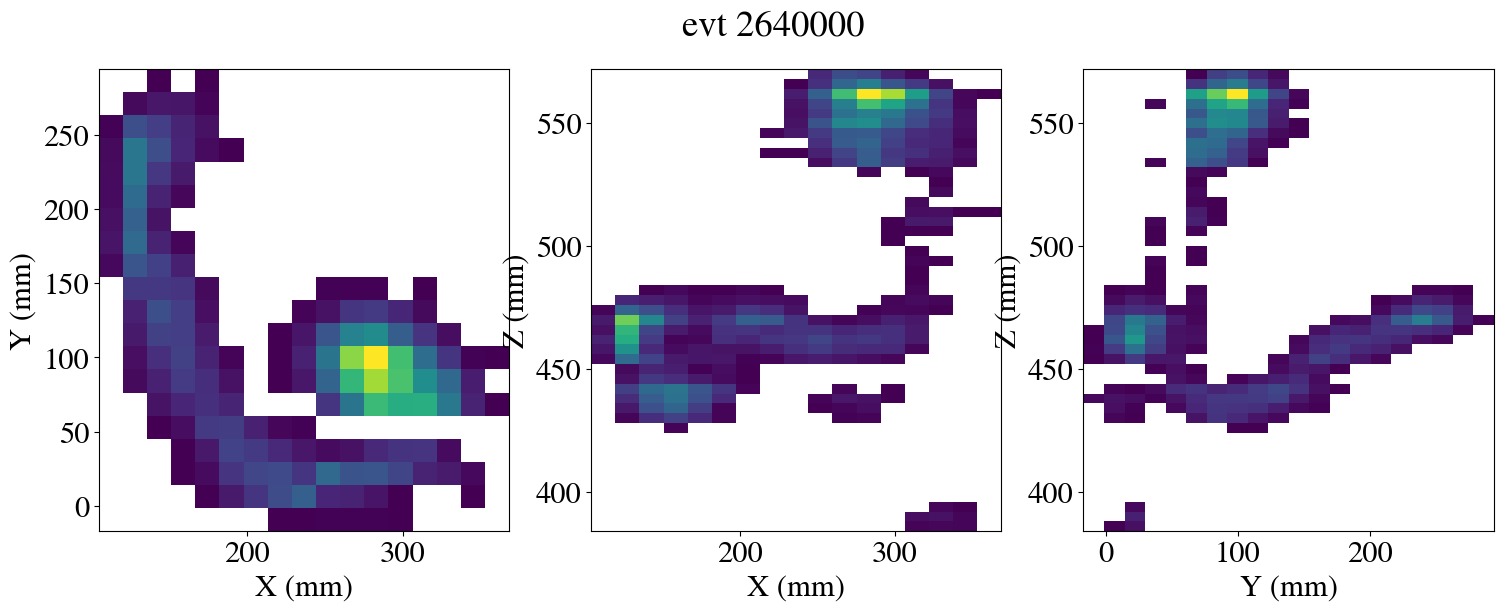

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640002


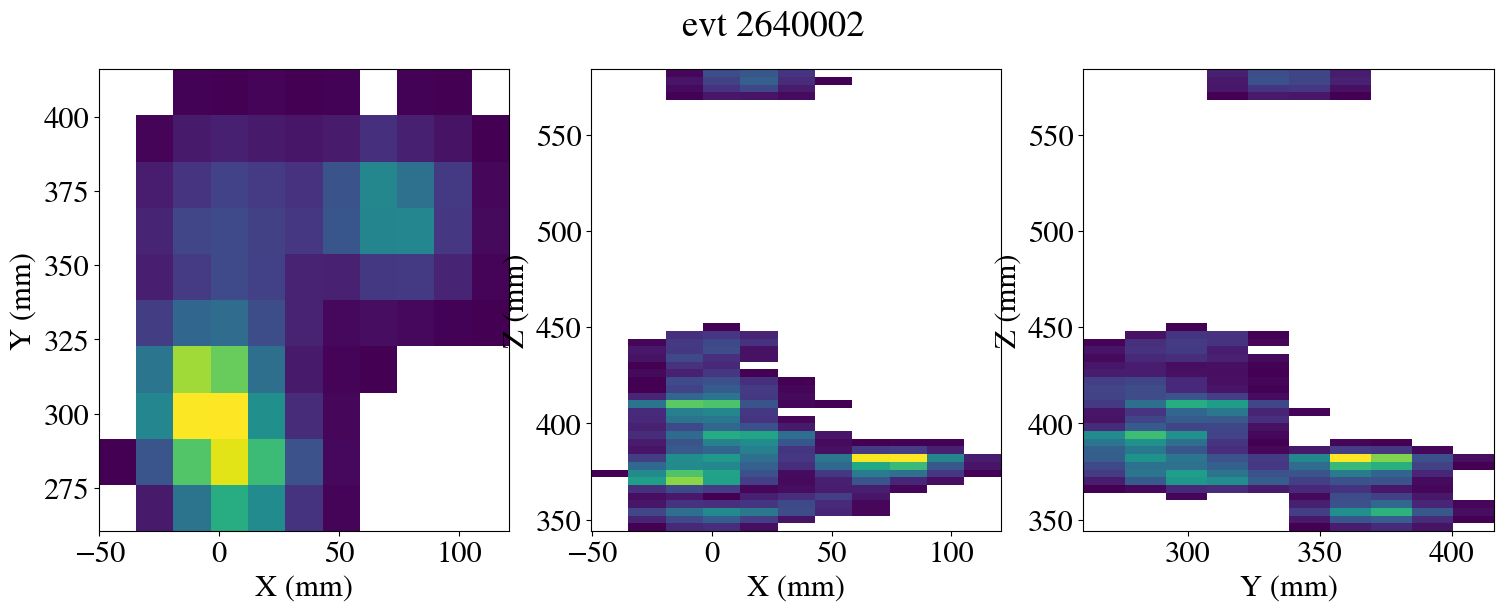

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640004


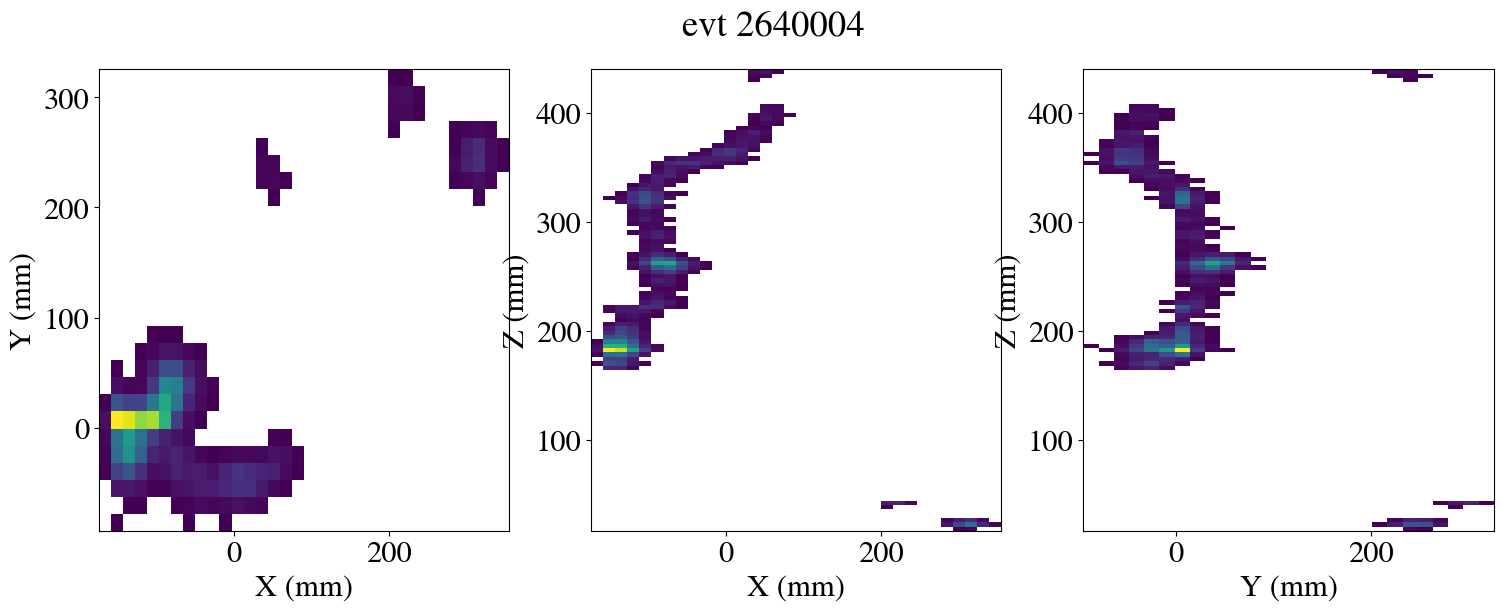

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640006


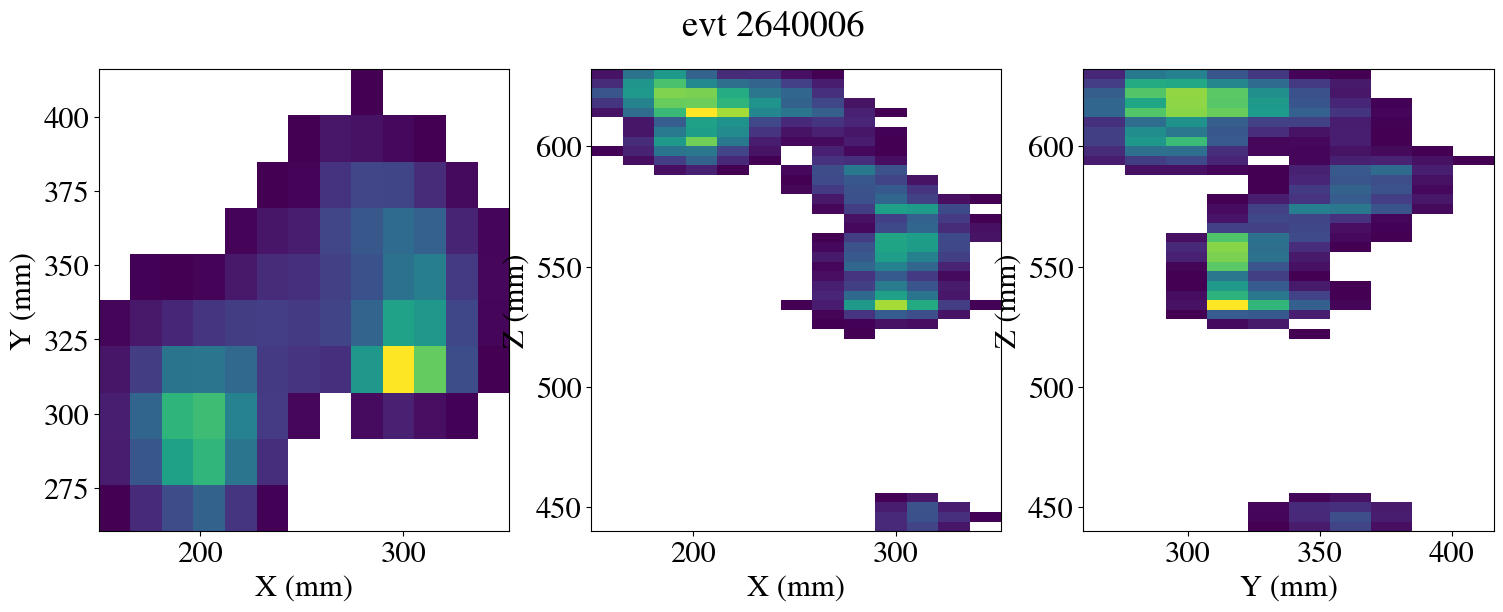

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640008


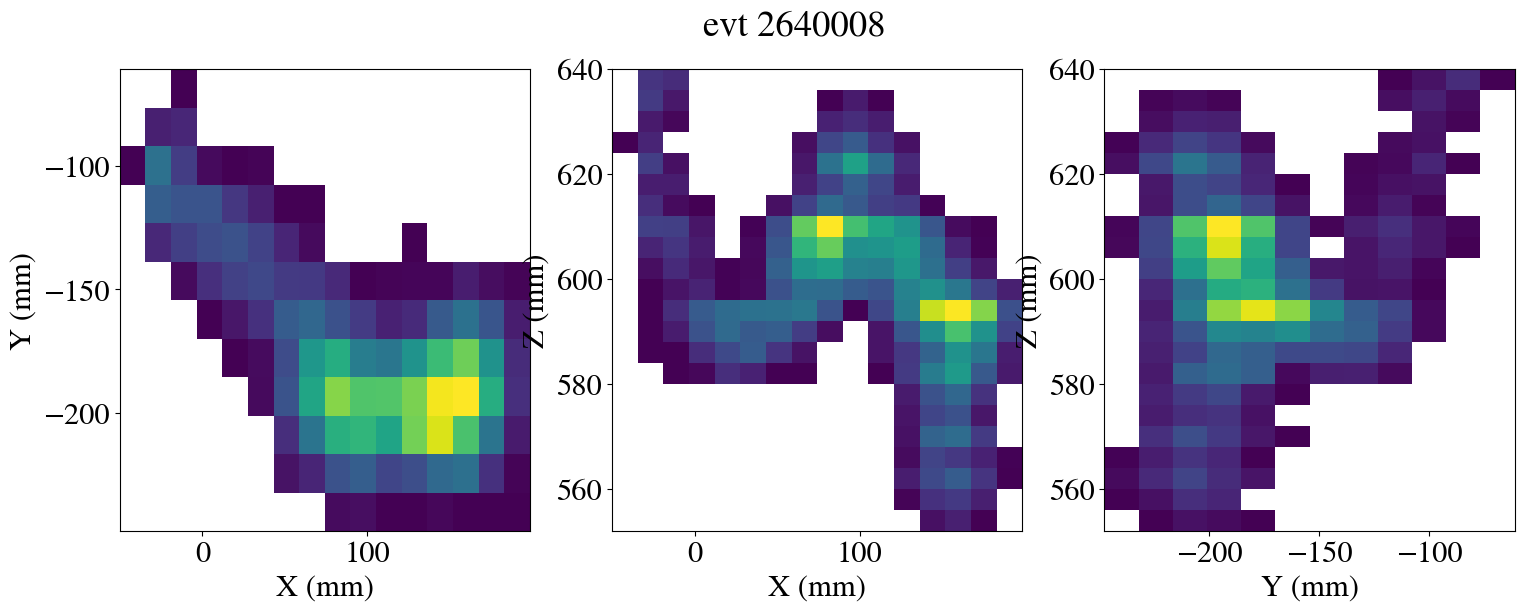

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640010


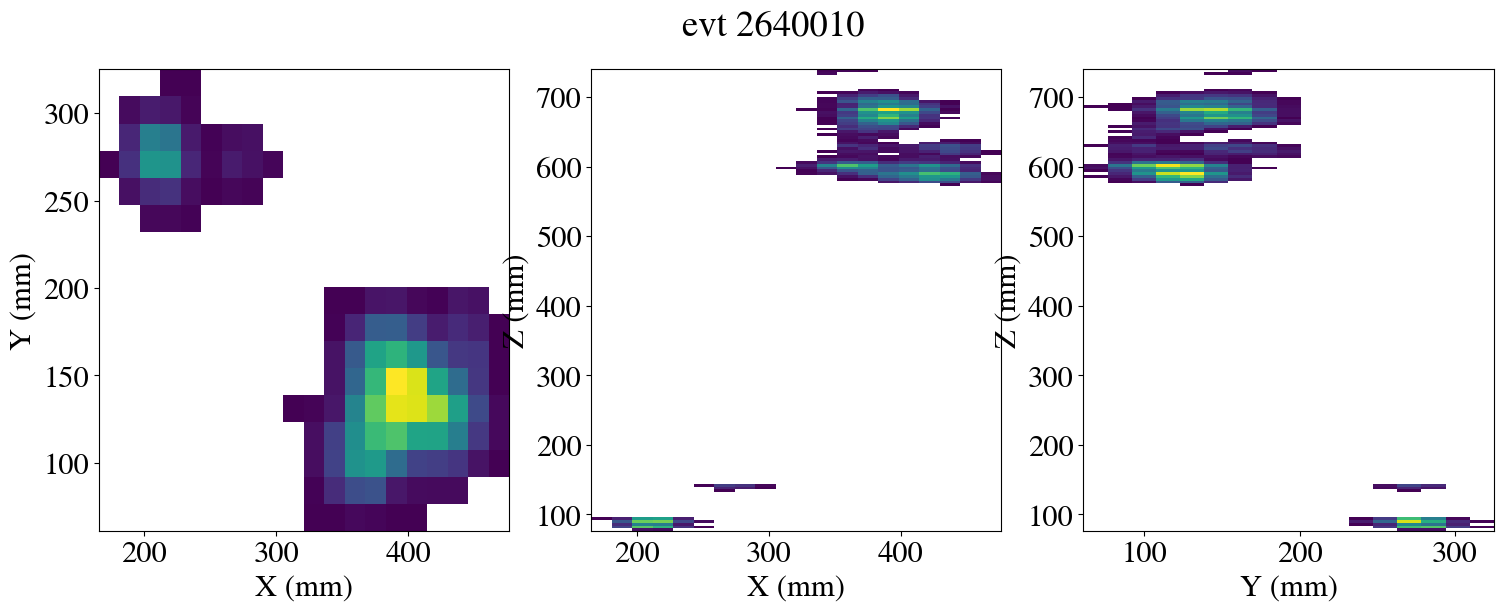

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640012


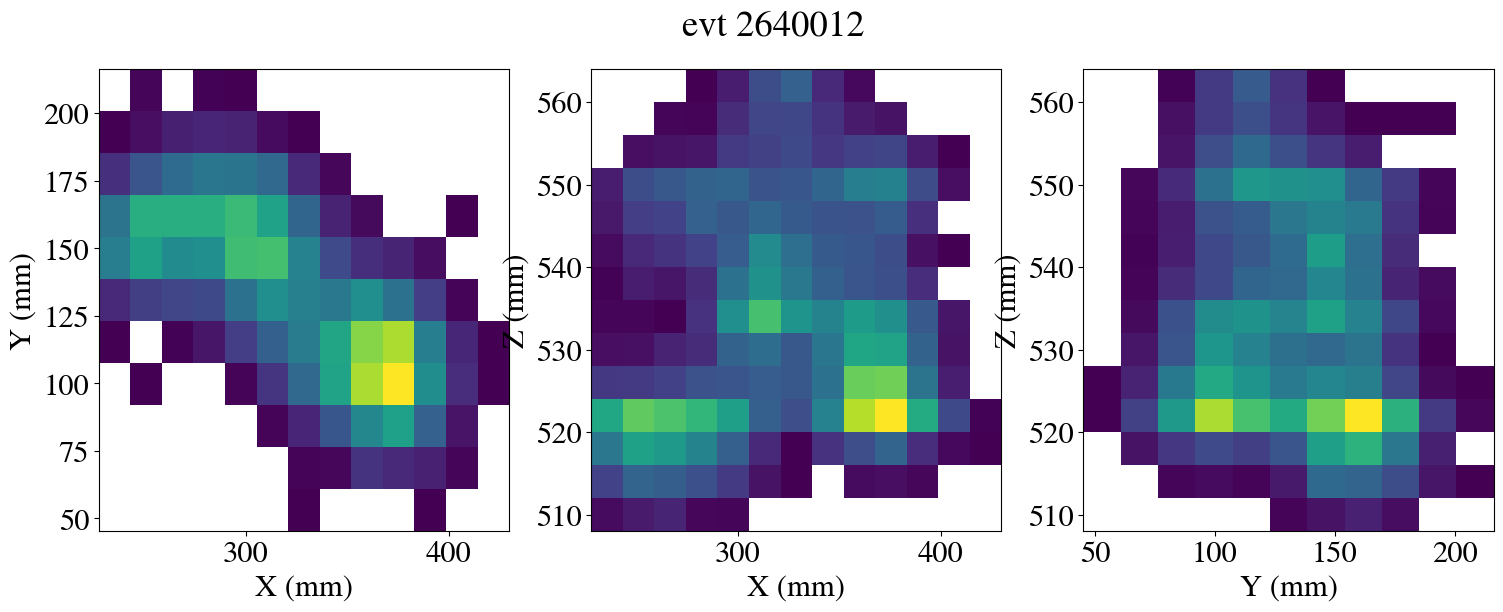

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640014


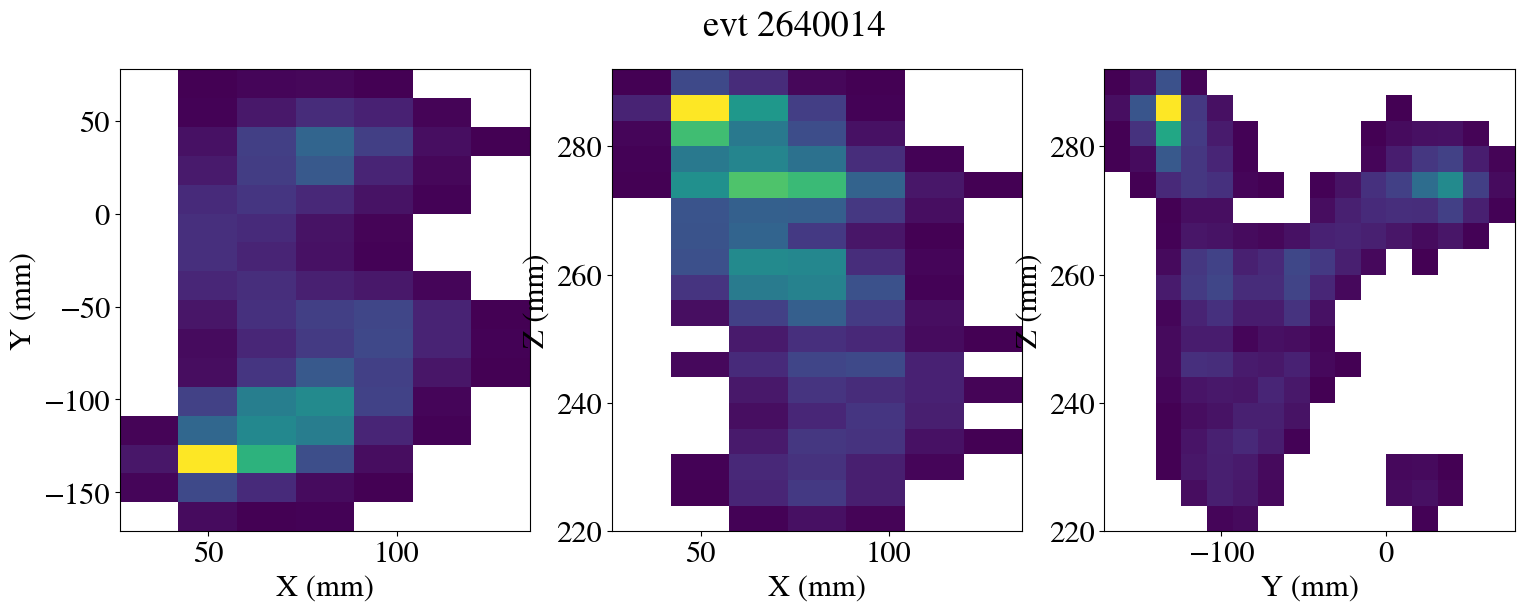

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640016


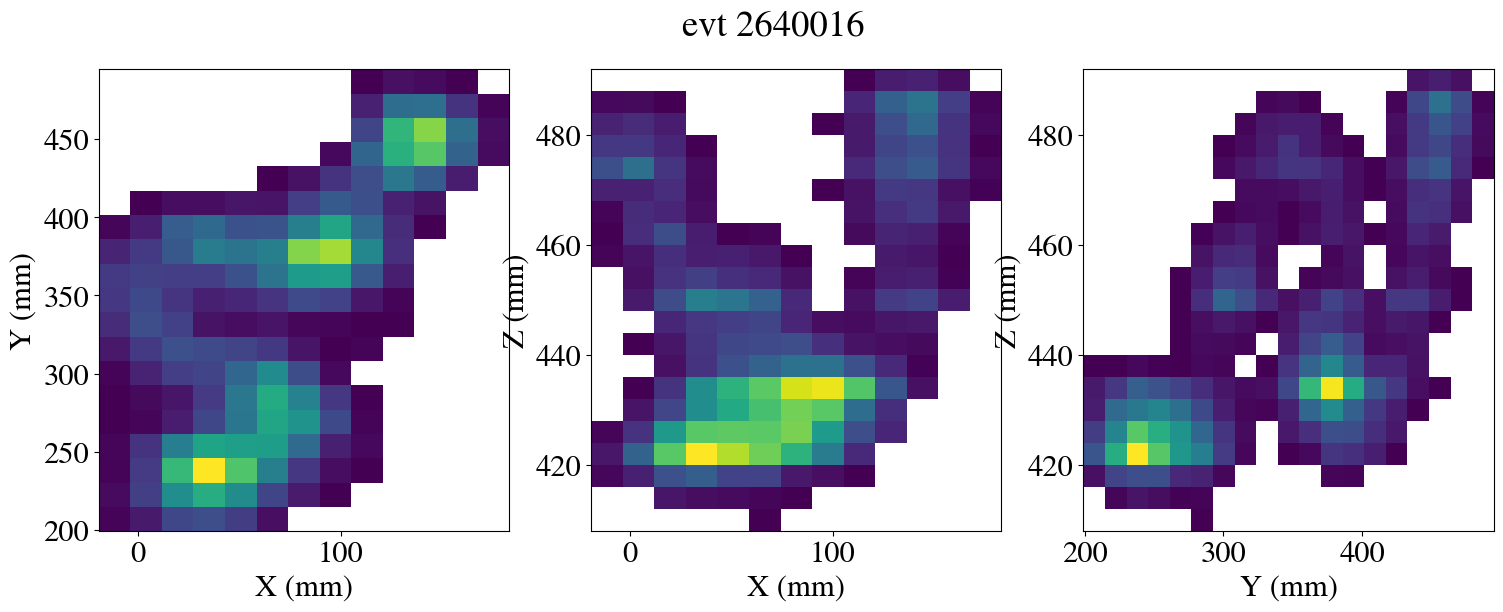

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640020


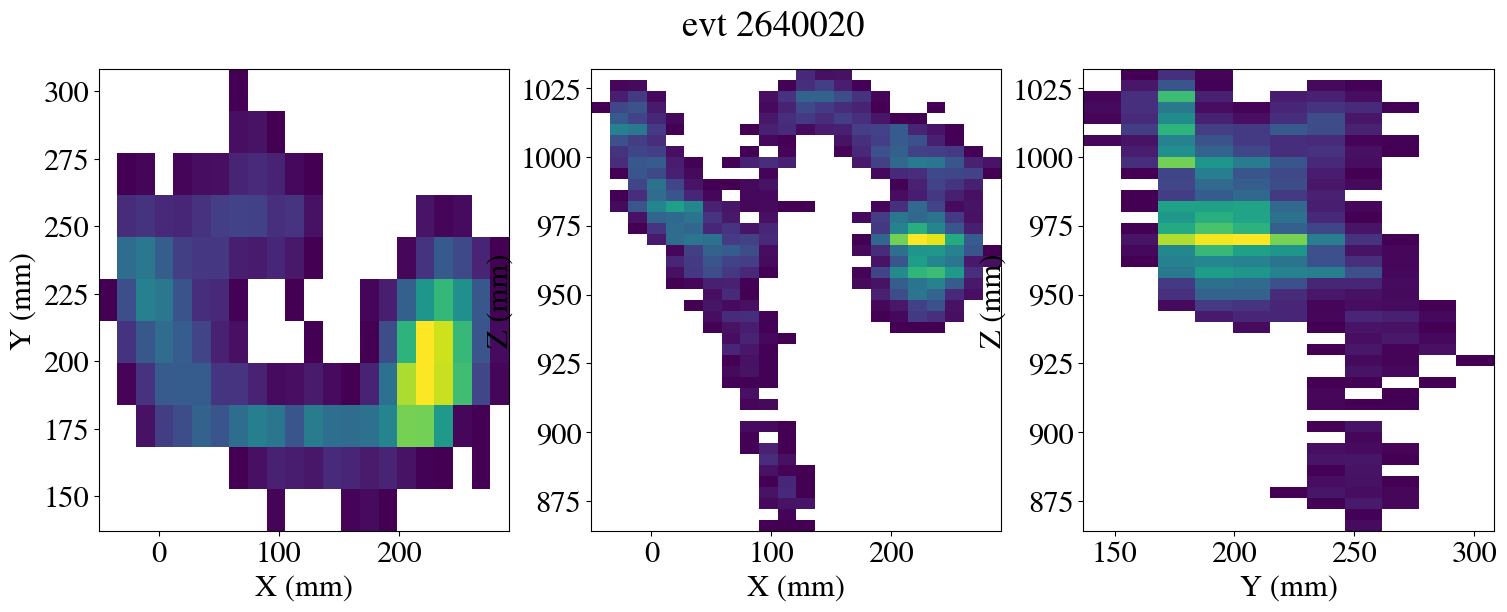

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640022


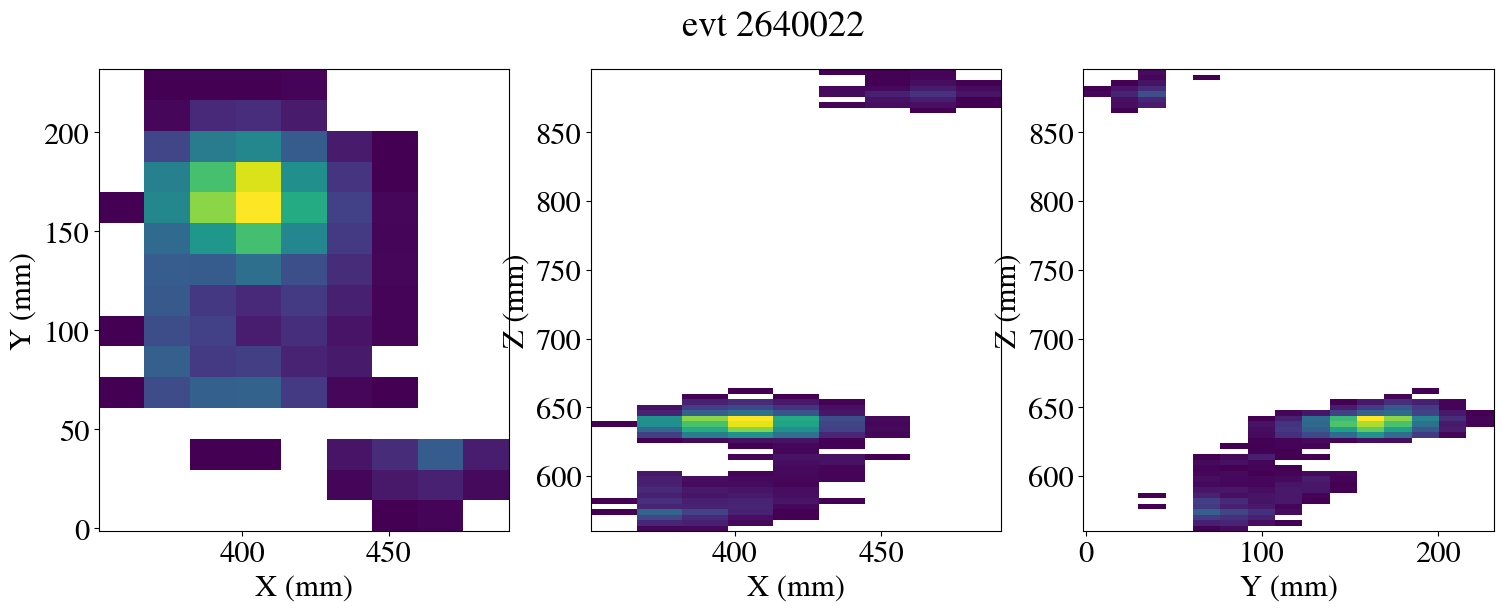

RUN NUMBER: 040925
TIMESTAMP: 456018
EVT: 2640024


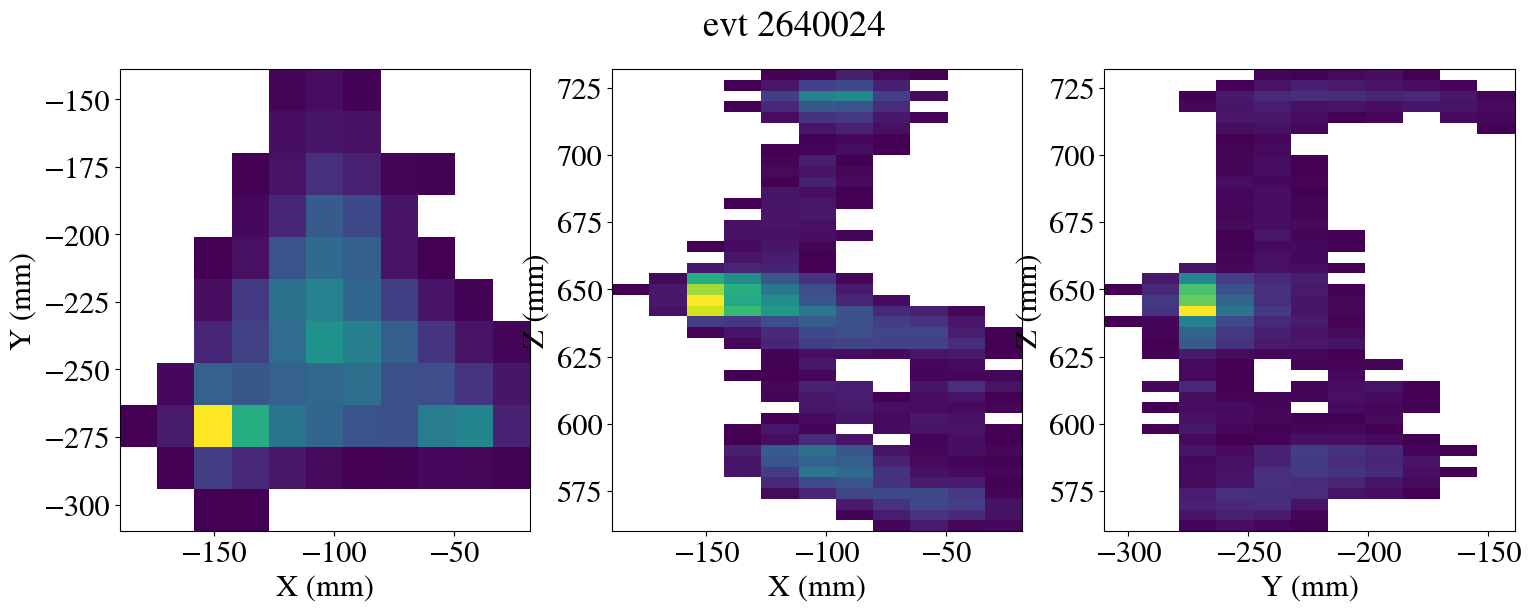

In [ ]:
stopper = 10
for q, (RN, TS) in enumerate(zip(RUN_NUMBERS, TIMESTAMPS)):
    folder_path = f'/{data_path}/halmazan/NEXT/{DATA_PATH}/{RN}/thekla/{TS}/ldc1/'
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    data = load_dst(file_paths[0], 'RECO', 'Events')

    
    for i, (evt, df) in enumerate(data.groupby('event')):
        print('='*20)
        print('='*20)
        print(f'RUN NUMBER: {RN}')
        print(f'TIMESTAMP: {TS}')
        print(f'EVT: {evt}')

        raw_plotter(df, evt)

        if i > stopper:
            break

# Plots

- Energy distribution and distribution of all variables

In [ ]:
hdst.columns.values

array(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min',
       'r_min', 'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave',
       'z_ave', 'r_ave', 'extreme1_x', 'extreme1_y', 'extreme1_z',
       'extreme2_x', 'extreme2_y', 'extreme2_z', 'blob1_x', 'blob1_y',
       'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z', 'eblob1', 'eblob2',
       'ovlp_blob_energy', 'vox_size_x', 'vox_size_y', 'vox_size_z'],
      dtype=object)

In [ ]:
top_vars  = ['length', 'numb_of_voxels',
             'numb_of_hits', 'numb_of_tracks']

top_labels = ['length (mm)', 'number of voxels',
              'number of hits', 'number of tracks']

geo_vars  = ['x_min', 'y_min', 'z_min',
             'r_min', 'x_max', 'y_max', 
             'z_max', 'r_max', 'x_ave',
             'y_ave', 'z_ave', 'r_ave']

geo_labels = ['(mm)'] * len(geo_vars)

blob_vars = ['extreme1_x', 'extreme1_y', 'extreme1_z',
             'extreme2_x', 'extreme2_y', 'extreme2_z', 
             'blob1_x', 'blob1_y', 'blob1_z', 
             'blob2_x', 'blob2_y', 'blob2_z', 
             'eblob1', 'eblob2',
             'ovlp_blob_energy']

blob_labels = ['mm'] * len(blob_vars[-3]) + ['Energy (MeV)'] * 3

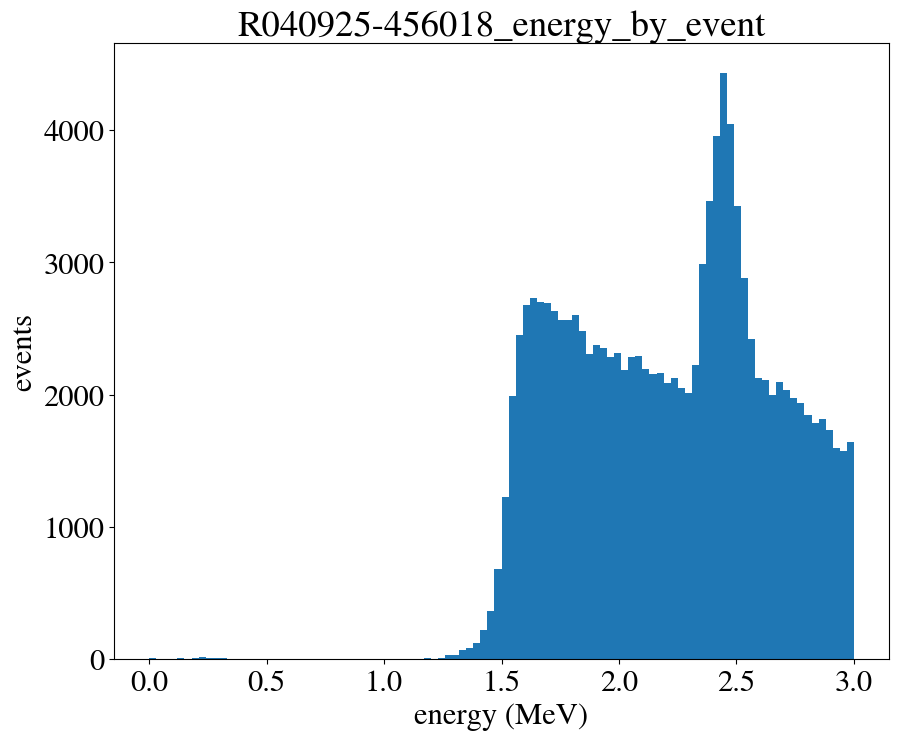

In [ ]:
func.plot_hist_over_column(hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_by_event'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

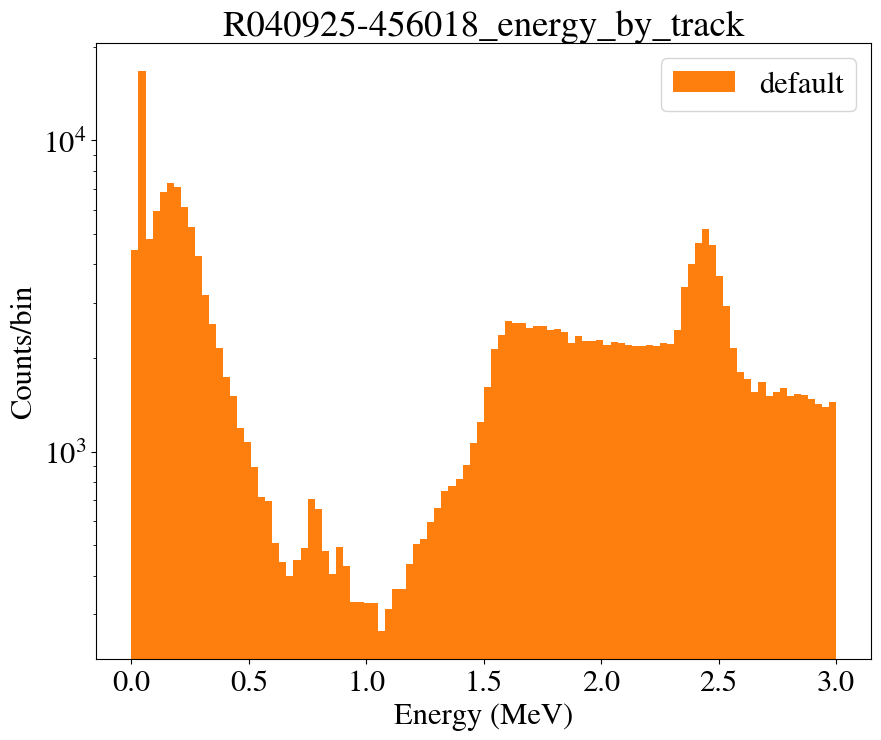

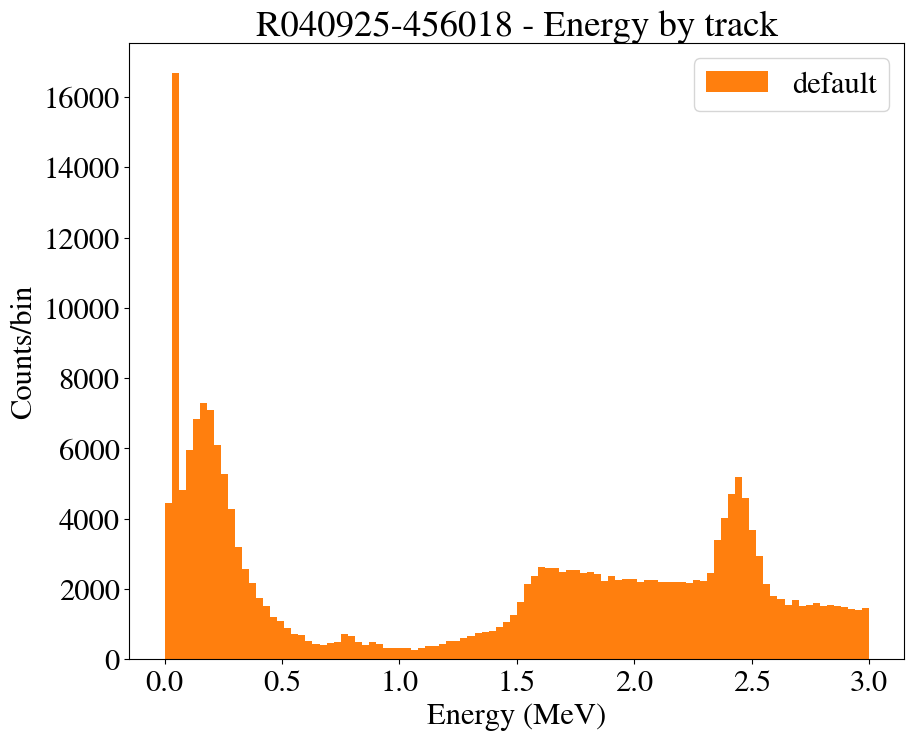

In [ ]:
func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_by_track'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP} - Energy by track'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = False
              , output  = True)

In [ ]:
log_flag = True

# Topological output

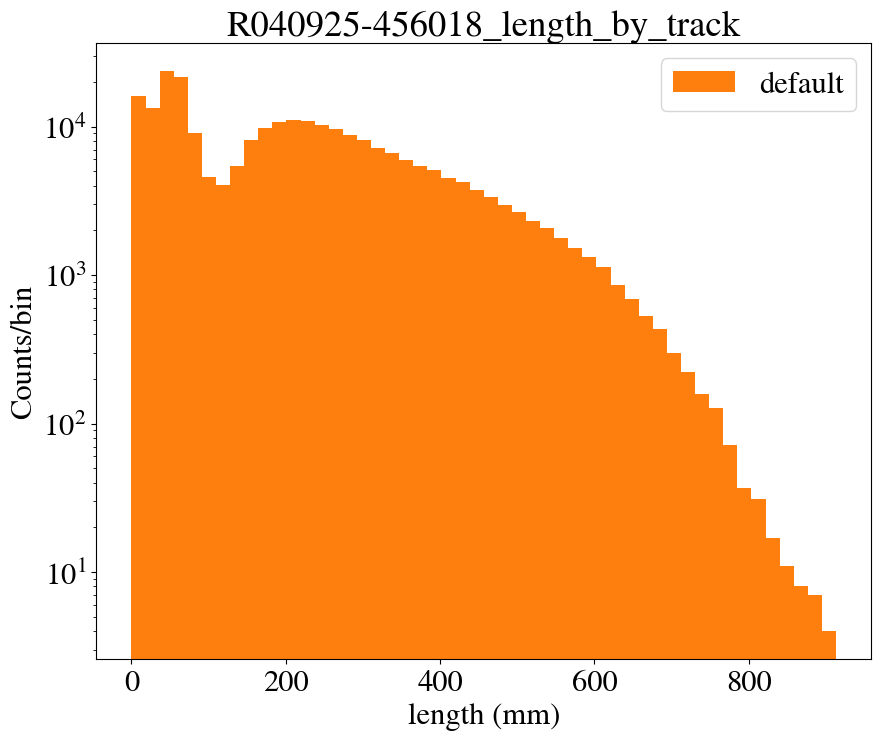

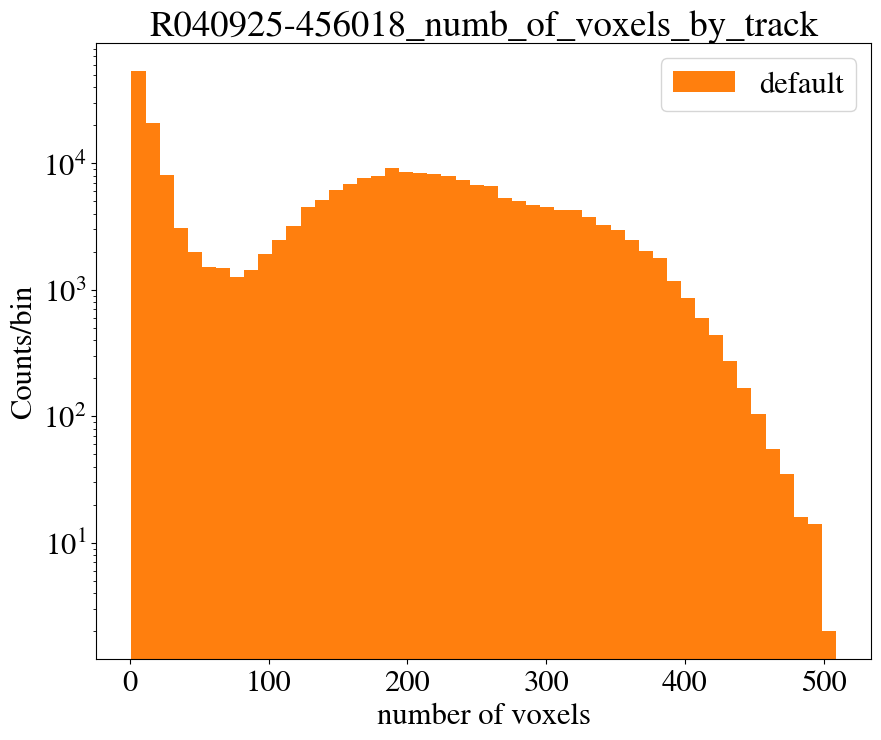

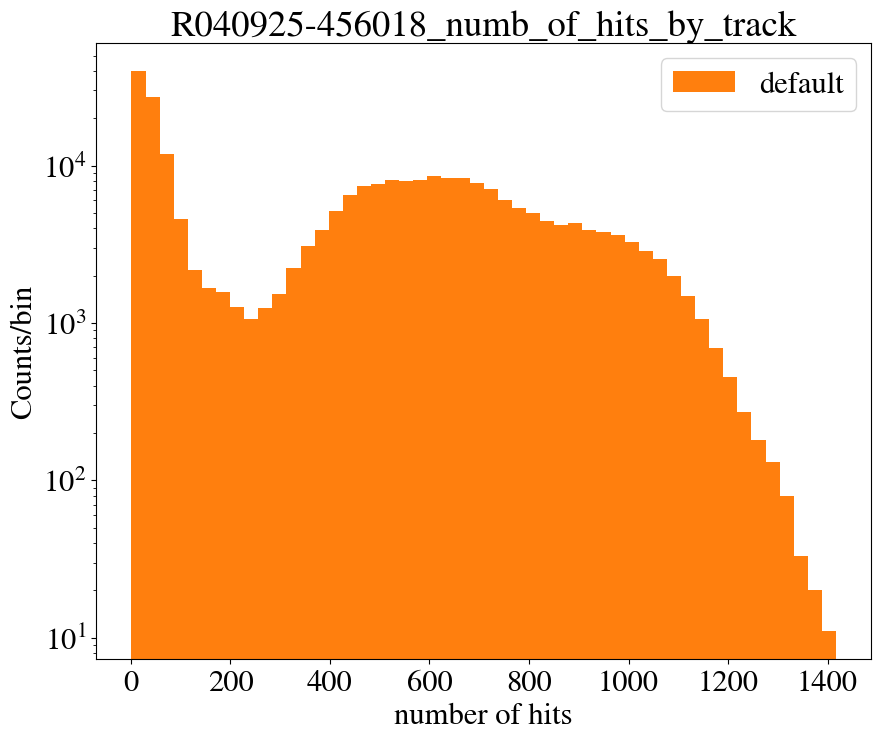

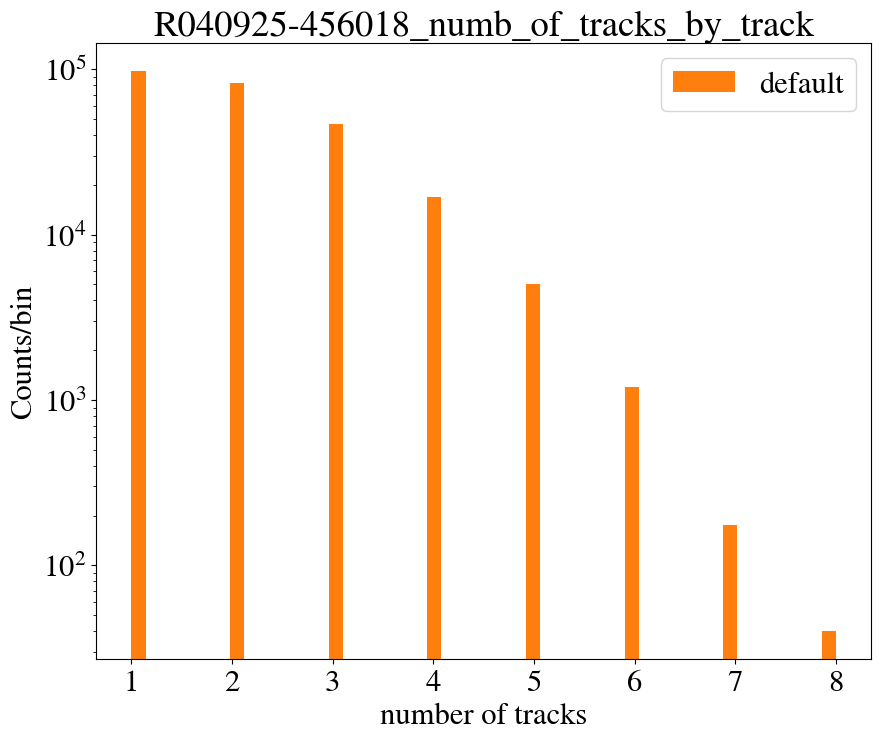

In [ ]:
for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_by_track'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')

# Geometric output

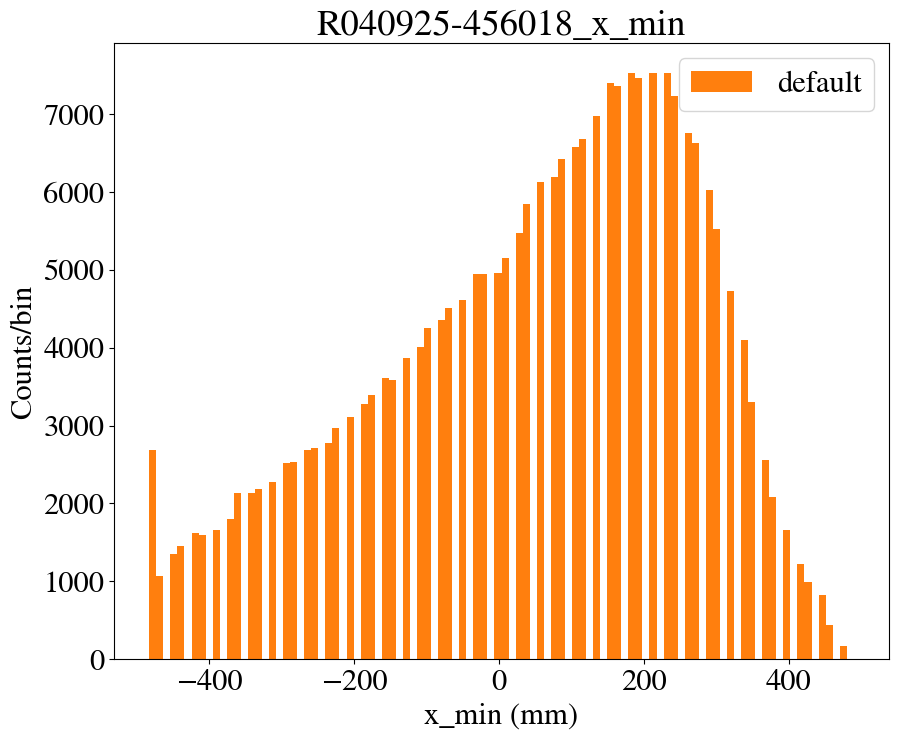

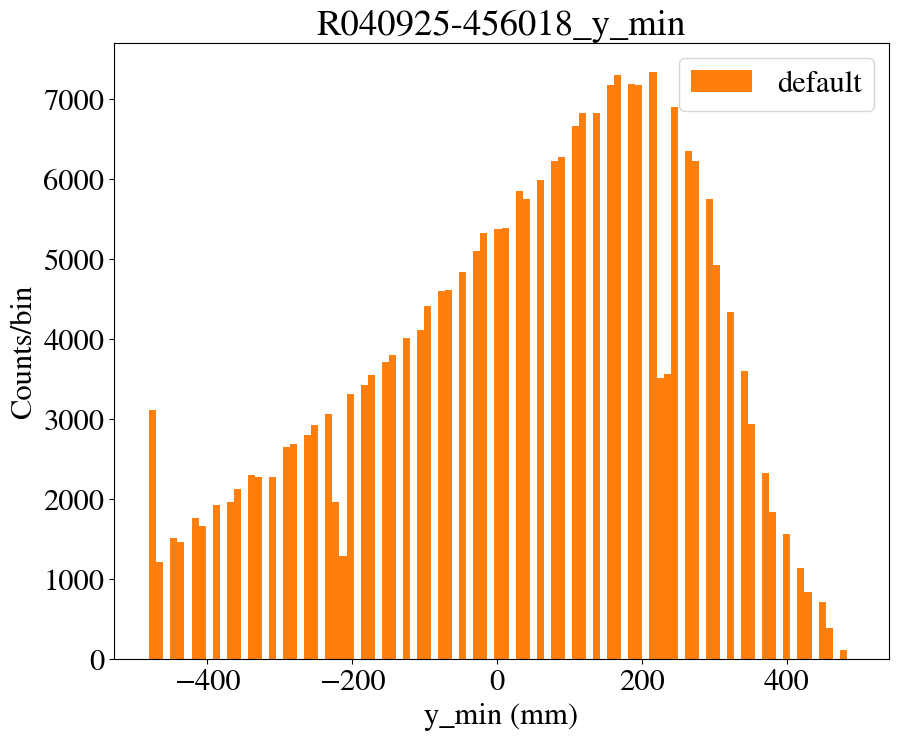

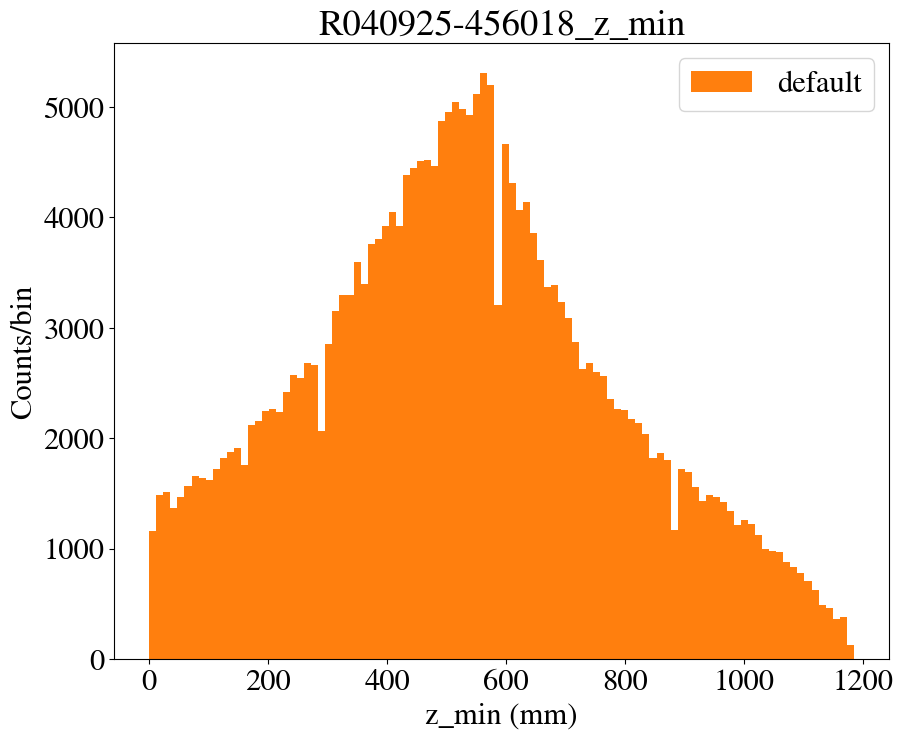

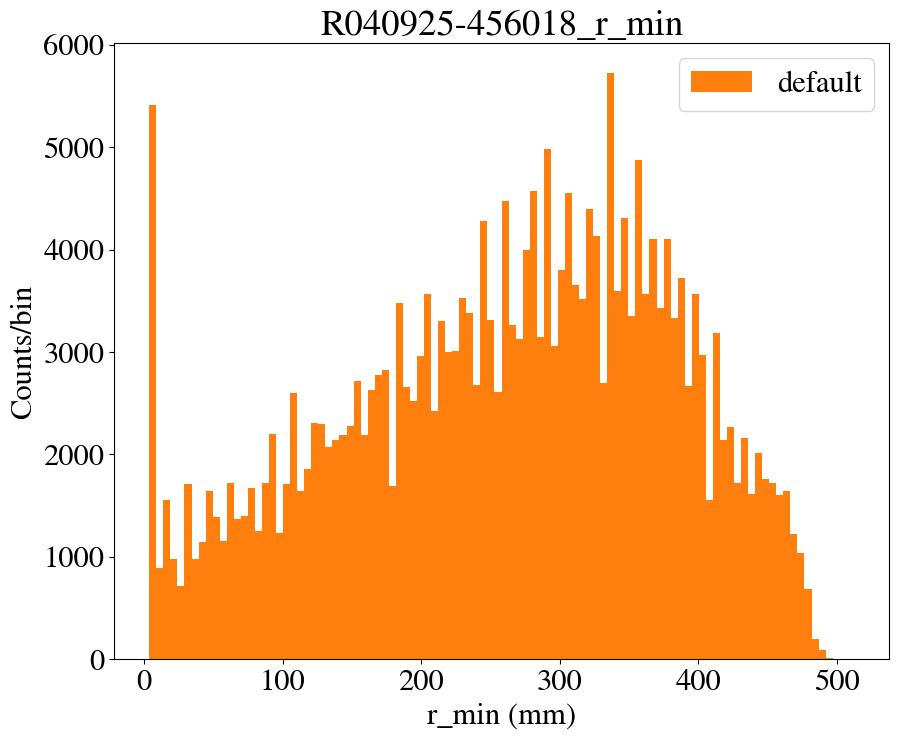

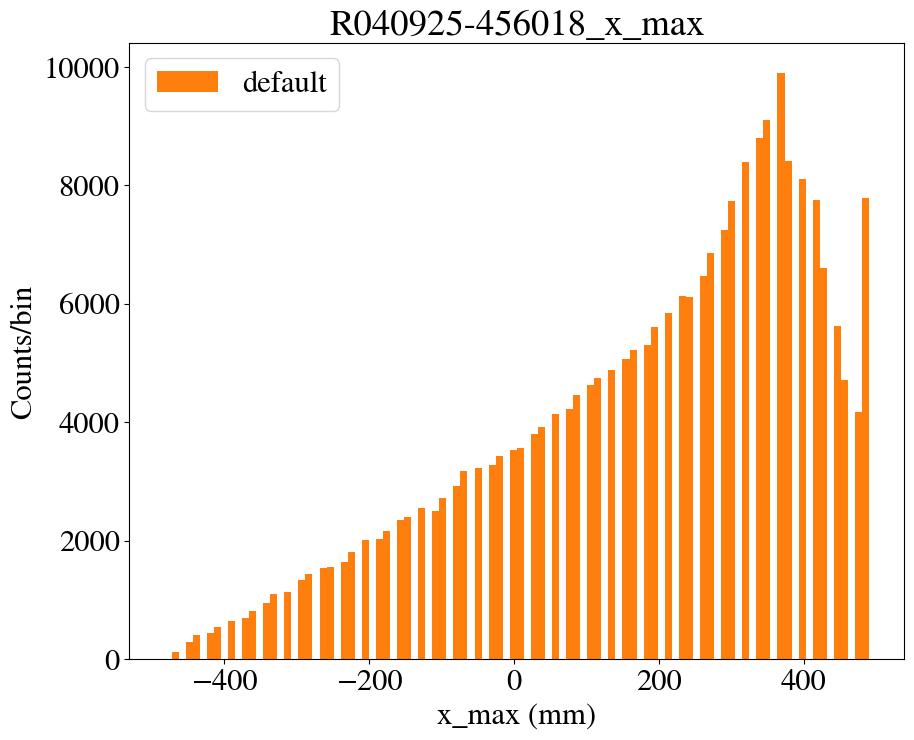

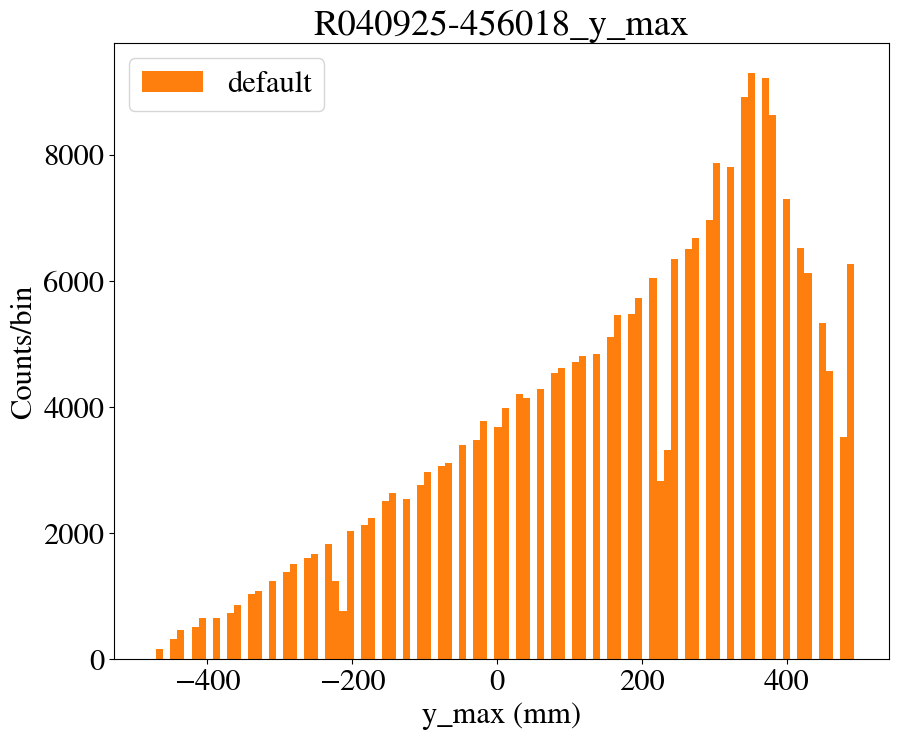

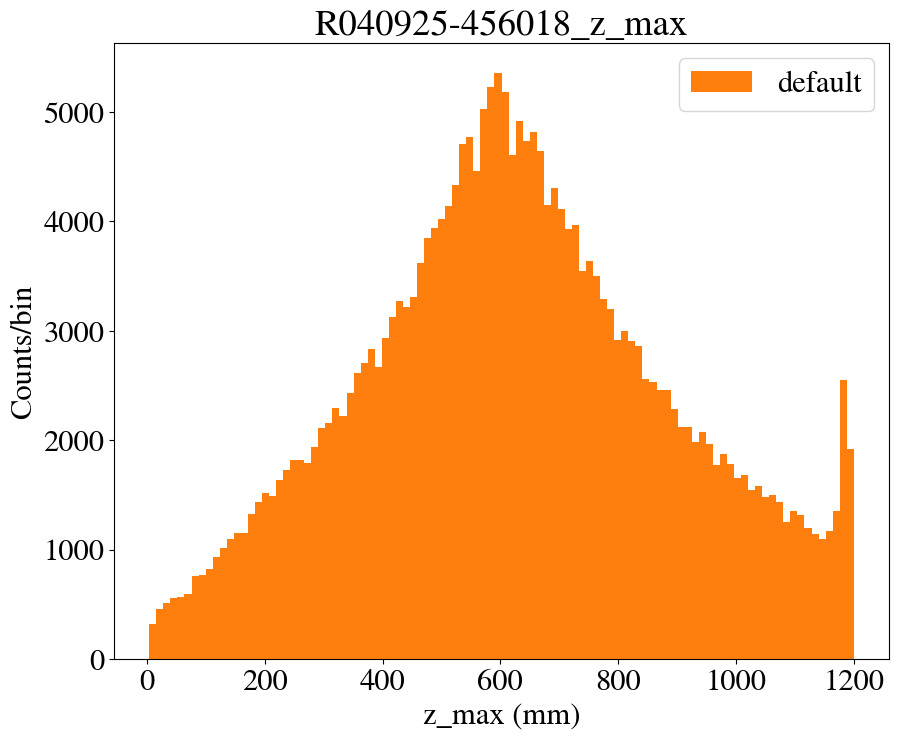

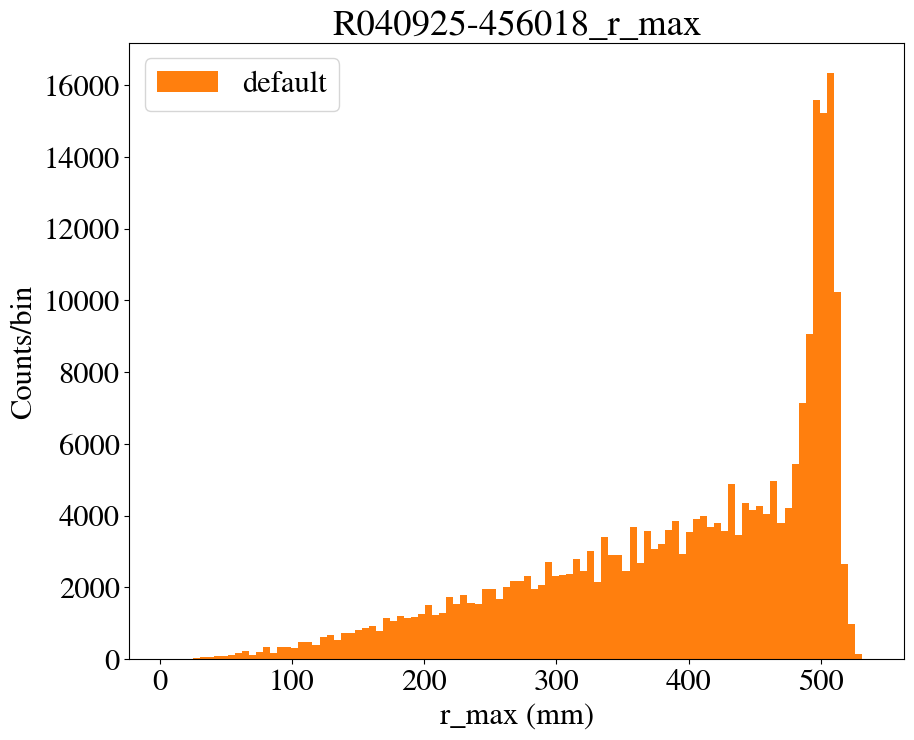

ValueError: supplied range of [nan, nan] is not finite

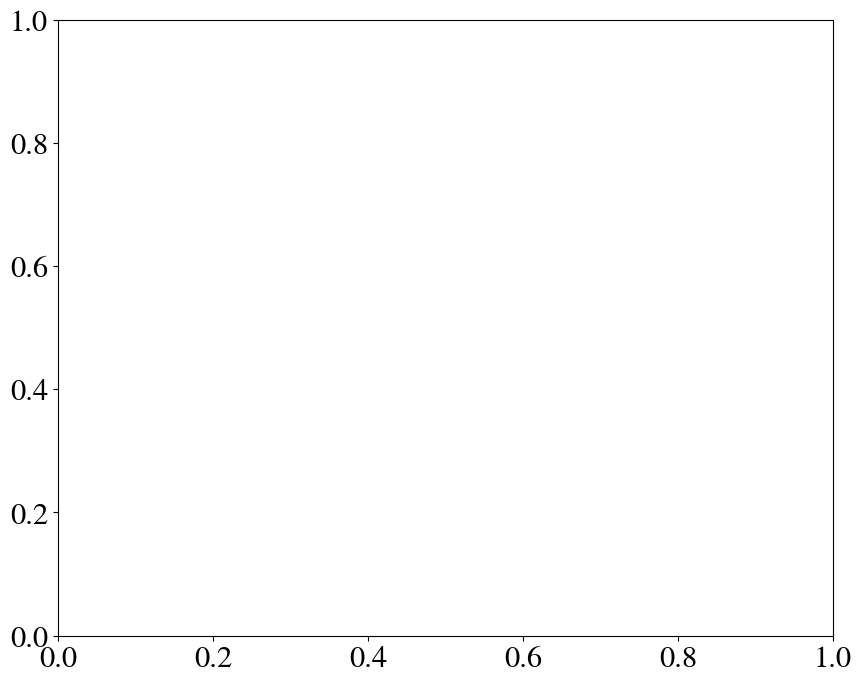

In [ ]:
log_flag = False
for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( hdst
                  , vars
                  , binning = 100
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')

# blob related output

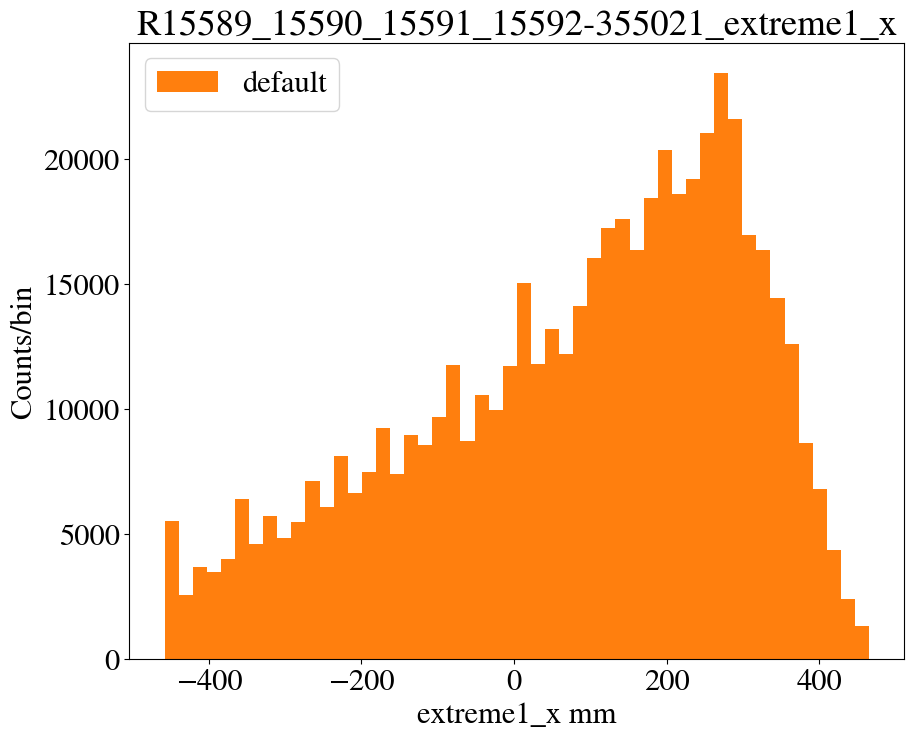

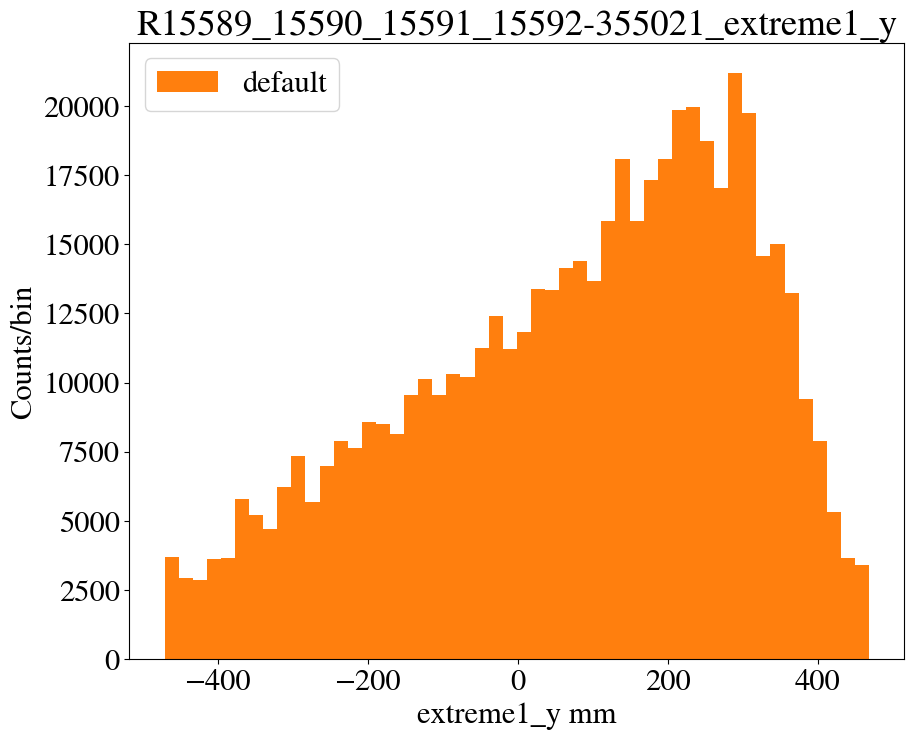

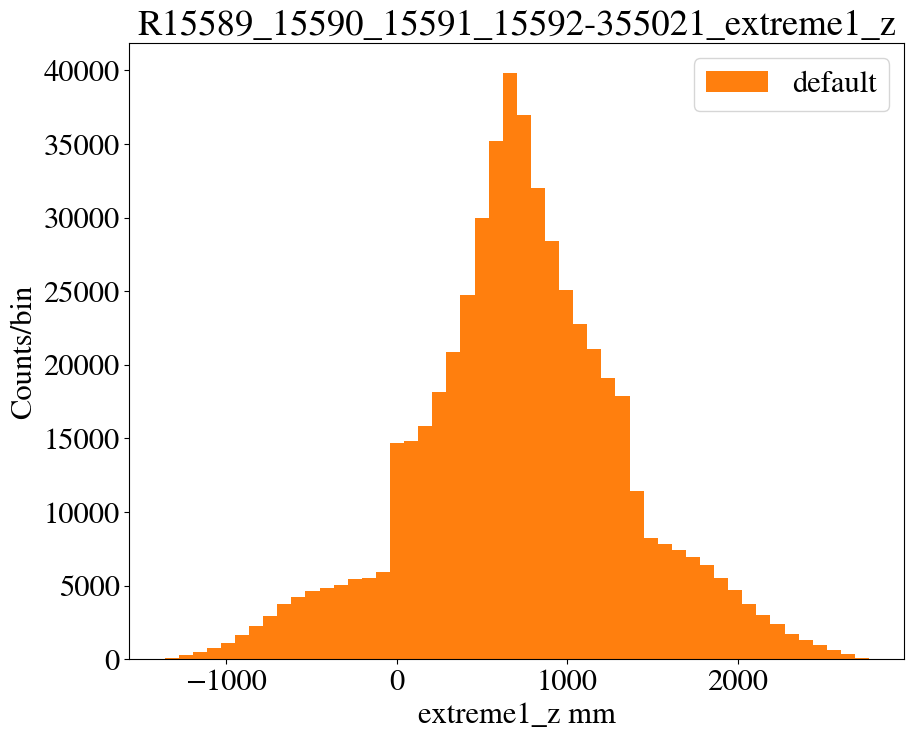

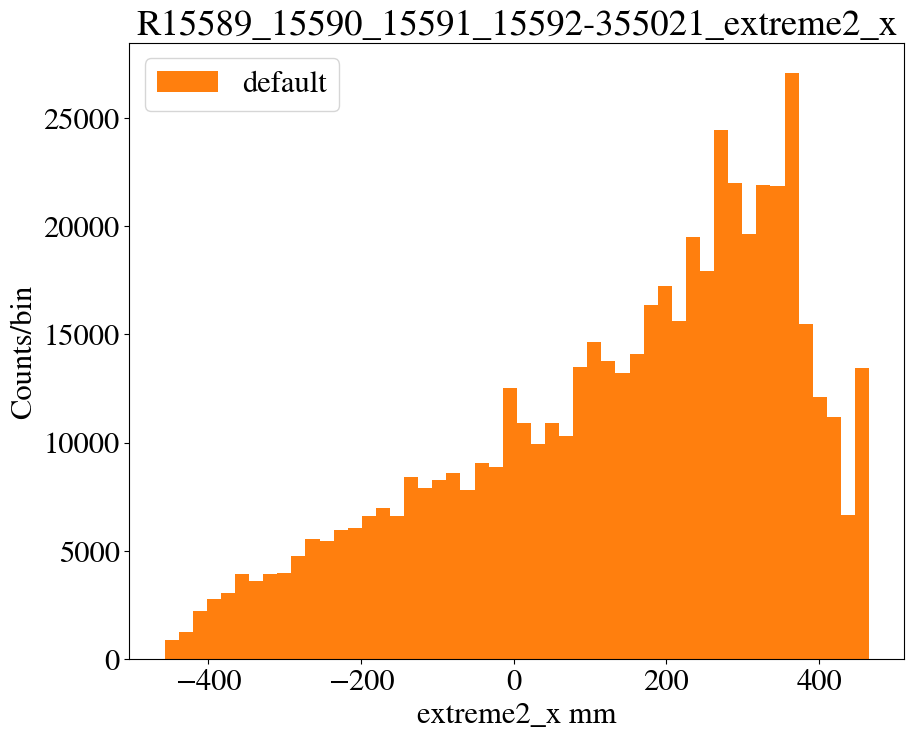

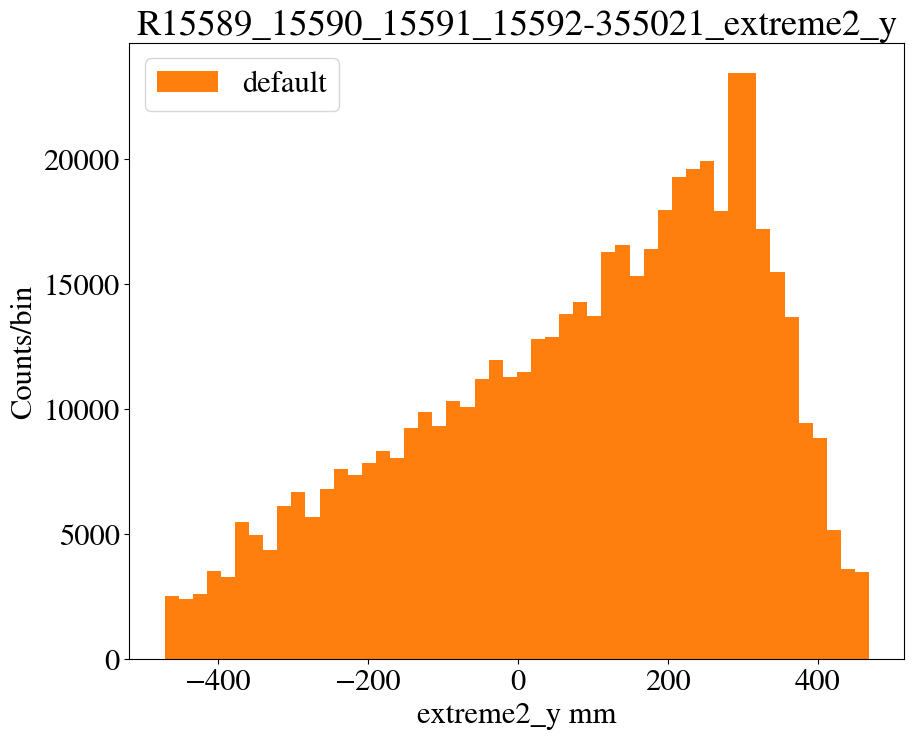

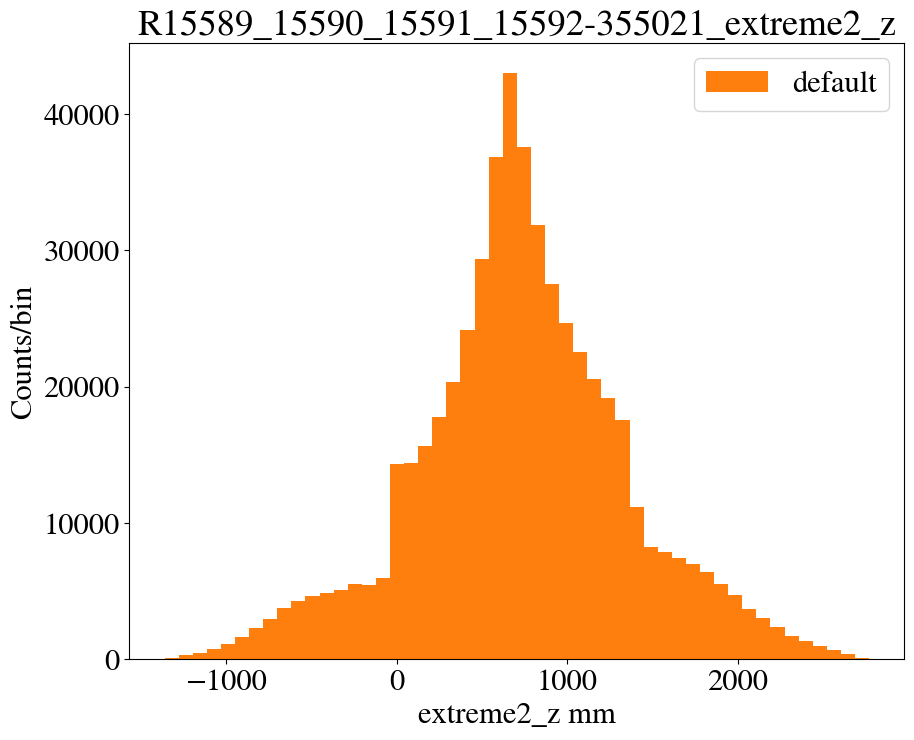

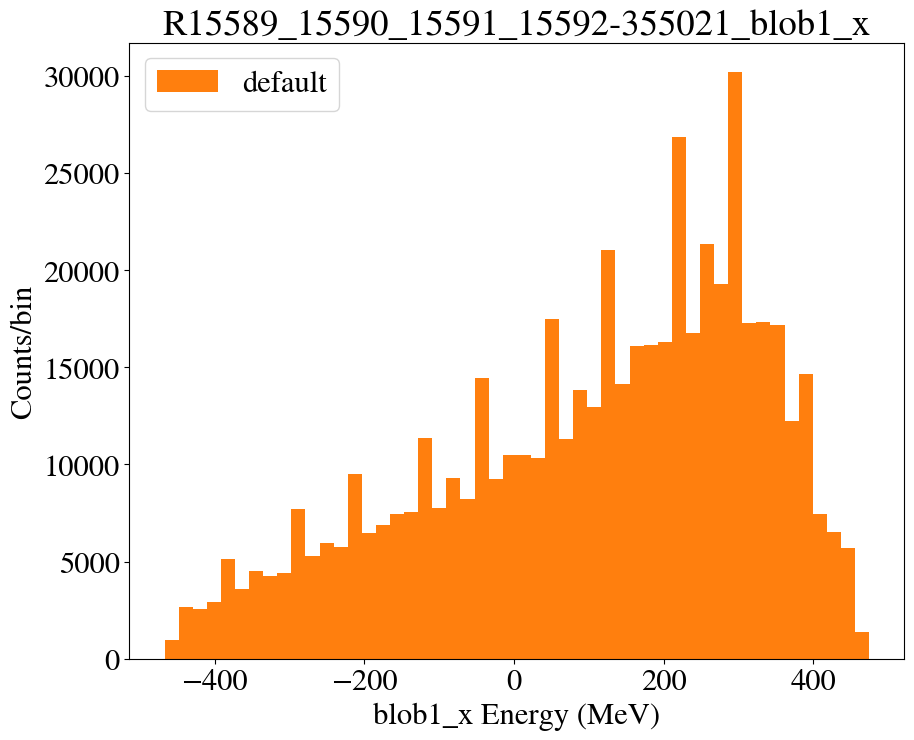

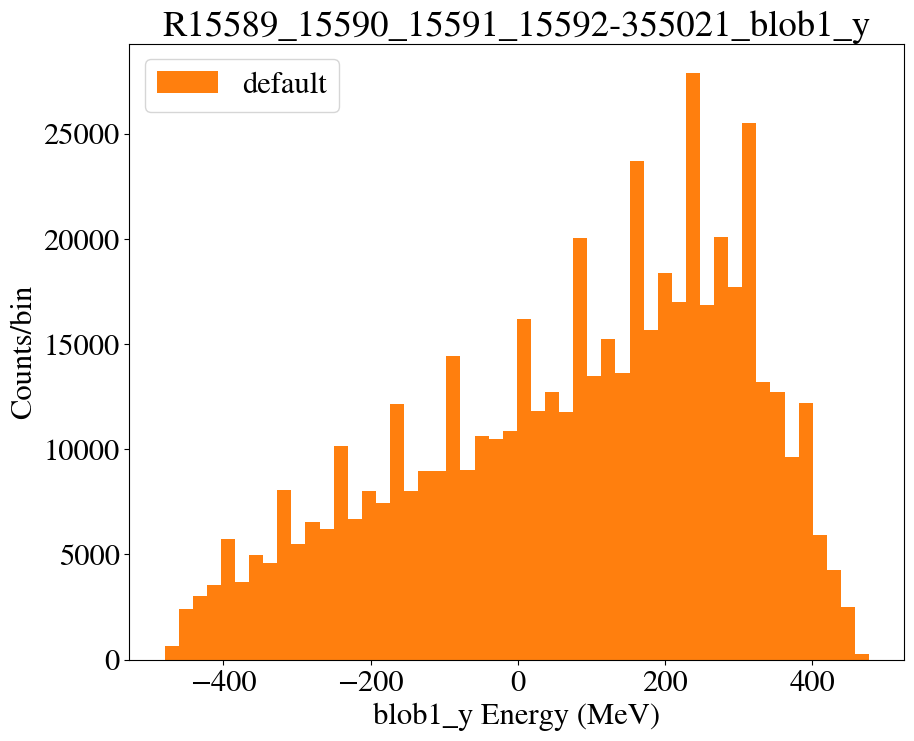

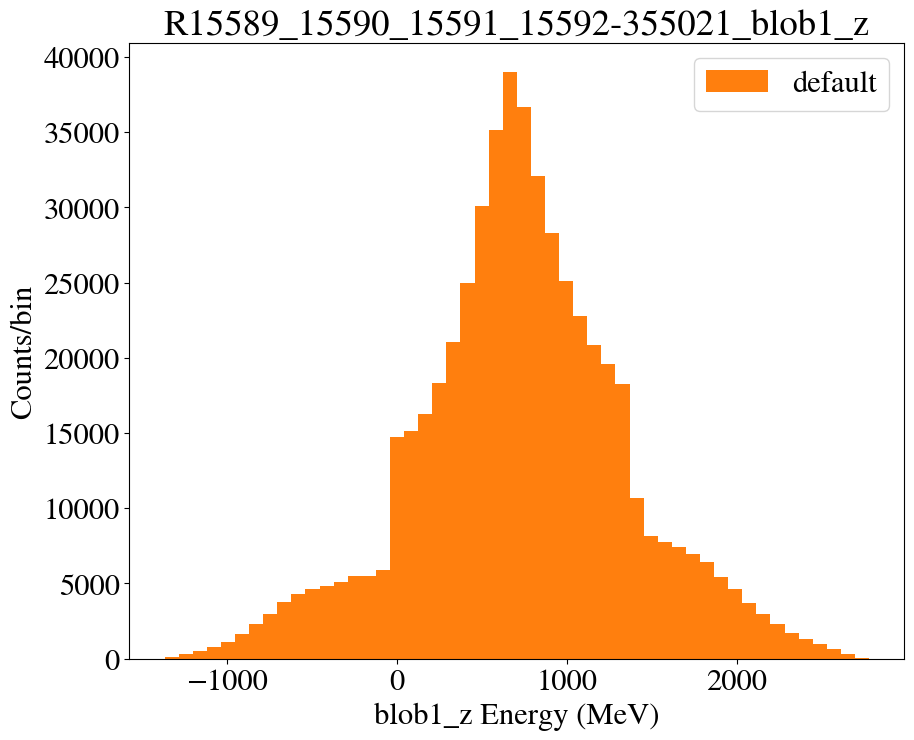

In [ ]:
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

# apply cuts and plot the same things

In [ ]:
#######################################################################################
#########################   CUT PARAMETERS   #####################################
#######################################################################################
low_z = 20
upp_z  = 1195
r_lim = 450
low_e = 1.5
upp_e = 1.7

In [ ]:
cut_hdst, efficiencies = func.apply_cuts(hdst, 
                                         lower_z = low_z, 
                                         upper_z = upp_z, 
                                         r_lim   = r_lim, 
                                         lower_e = low_e, 
                                         upper_e = upp_e)

display(efficiencies)

Cutting events around fiducial volume related to:
Z range between 20 and 1195
Radius range < 450
Fiducial track cut
Relative Cut efficiency:
Efficiency: 42.00 %
Absolute Cut efficiency:
Efficiency: 42.00 %
One track cut
Relative Cut efficiency:
Efficiency: 69.45 %
Absolute Cut efficiency:
Efficiency: 60.89 %

Blob overlap cut
Relative Cut efficiency:
Efficiency: 84.90 %
Absolute Cut efficiency:
Efficiency: 52.05 %
Energy cut
Relative Cut efficiency:
Efficiency: 4.63 %
Absolute Cut efficiency:
Efficiency: 9.71 %


Cut  Relative Efficiency  Relative Events  \
0            No cuts           100.000000           159626   
1      Fiducial Cuts            42.003809            67049   
2      One track cut            69.450700            46566   
3  Blob overlap cuts            84.901001            39535   
4        Energy cuts             4.633869             1832   

   Single Cut Efficiency  
0             100.000000  
1              42.003809  
2              60.894842  
3              52.048538  
4               9.712077

In [24]:
# SAVE THE DATAFRAME
cut_hdst.to_hdf(f'{folder_name}{RUN_NUMBER}_{TIMESTAMP}.h5', key = 'Tracking/Tracks')

In [25]:
# save the efficiency table
efficiencies.to_csv(f'{folder_name}efficiency.csv')

In [26]:
print(f'{folder_name}efficiency.csv')
display(pd.read_csv(f'{folder_name}efficiency.csv'))

/scratch/halmazan/NEXT/testing/notebooks/040925_456018_thekla/efficiency.csv


Unnamed: 0                Cut  Relative Efficiency  Relative Events  \
0           0            No cuts           100.000000           159626   
1           1      Fiducial Cuts            42.003809            67049   
2           2      One track cut            69.450700            46566   
3           3  Blob overlap cuts            84.901001            39535   
4           4        Energy cuts             4.633869             1832   

   Single Cut Efficiency  
0             100.000000  
1              42.003809  
2              60.894842  
3              52.048538  
4               9.712077

In [27]:
# check a different one quickly
print(folder_name)
folder_check = folder_name
print(f'{folder_check}efficiency.csv')
display(pd.read_csv(f'{folder_check}efficiency.csv'))

/scratch/halmazan/NEXT/testing/notebooks/040925_456018_thekla/
/scratch/halmazan/NEXT/testing/notebooks/040925_456018_thekla/efficiency.csv


Unnamed: 0                Cut  Relative Efficiency  Relative Events  \
0           0            No cuts           100.000000           159626   
1           1      Fiducial Cuts            42.003809            67049   
2           2      One track cut            69.450700            46566   
3           3  Blob overlap cuts            84.901001            39535   
4           4        Energy cuts             4.633869             1832   

   Single Cut Efficiency  
0             100.000000  
1              42.003809  
2              60.894842  
3              52.048538  
4               9.712077

# And plot again

disable the `log_flag` for low statistics

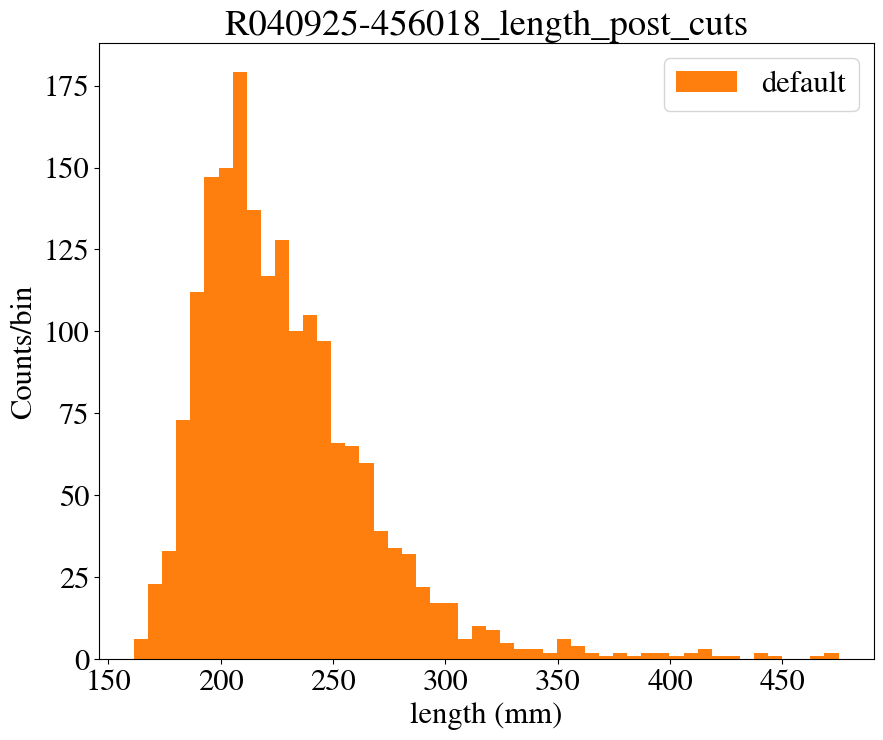

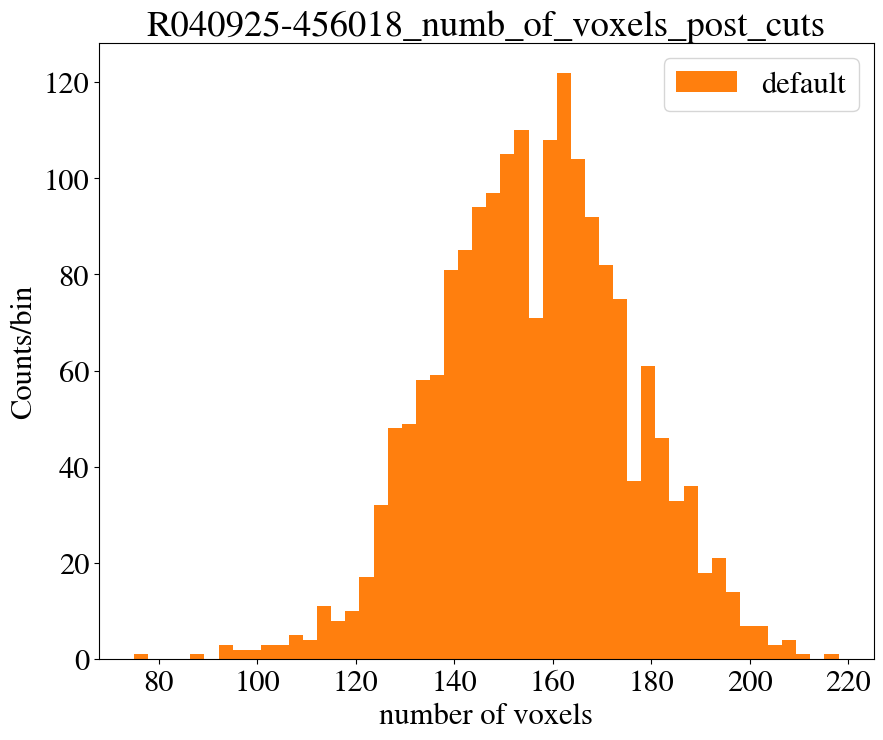

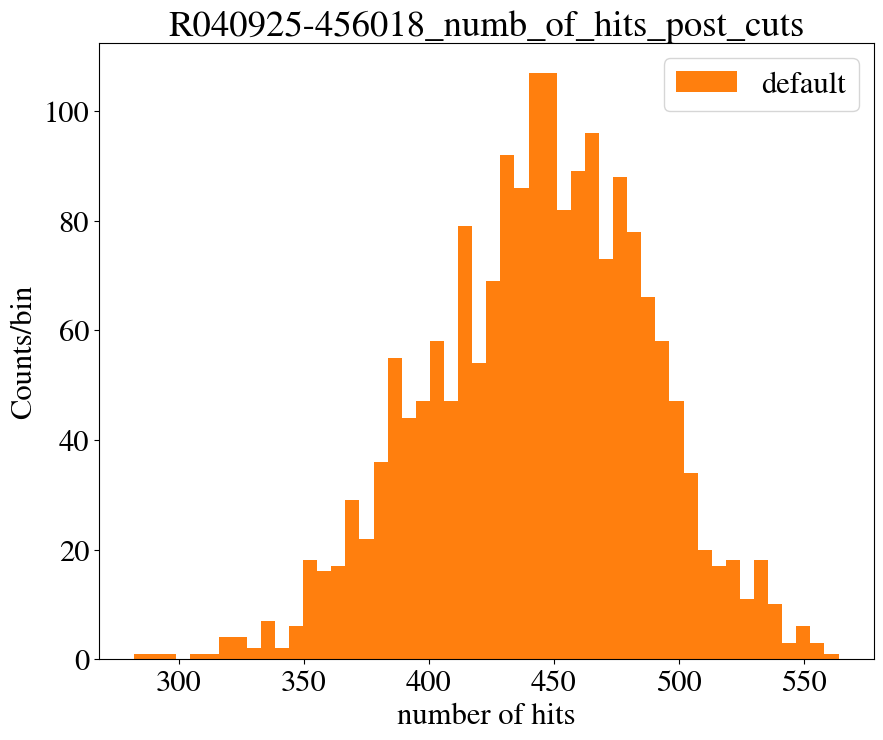

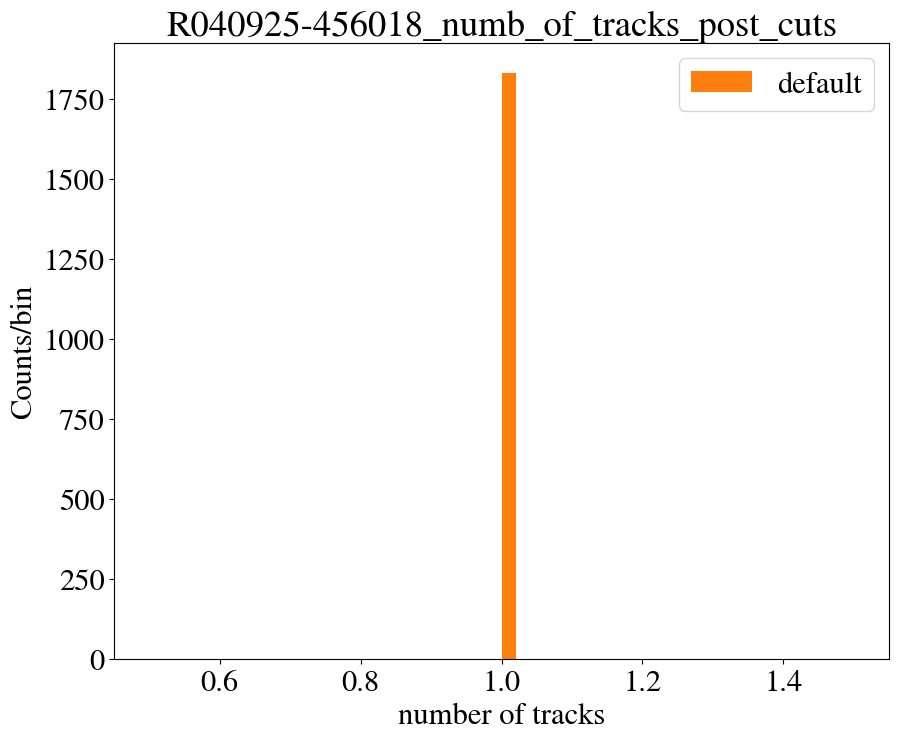

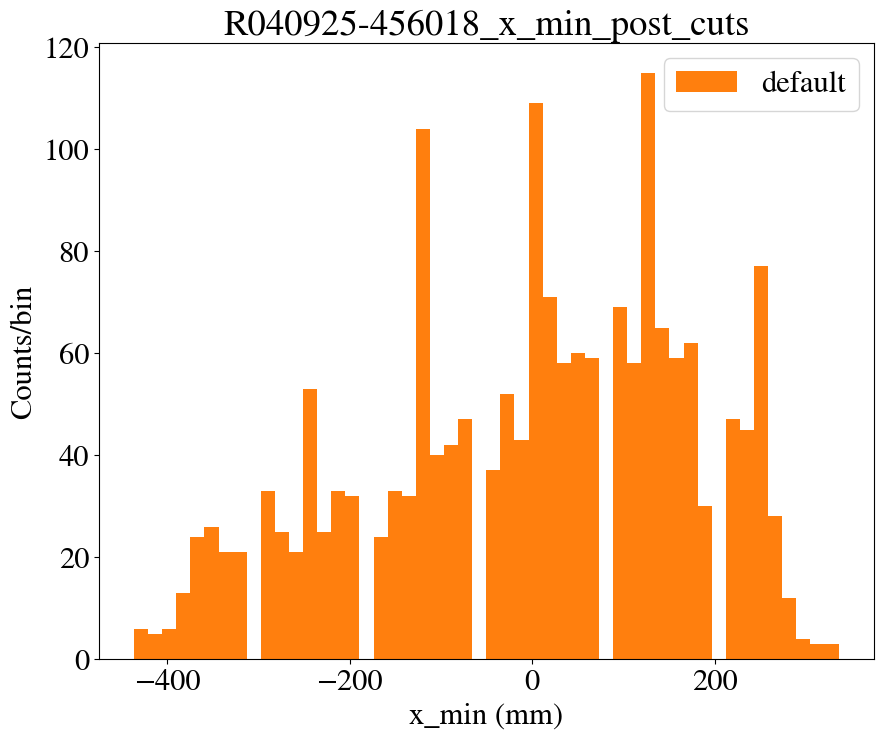

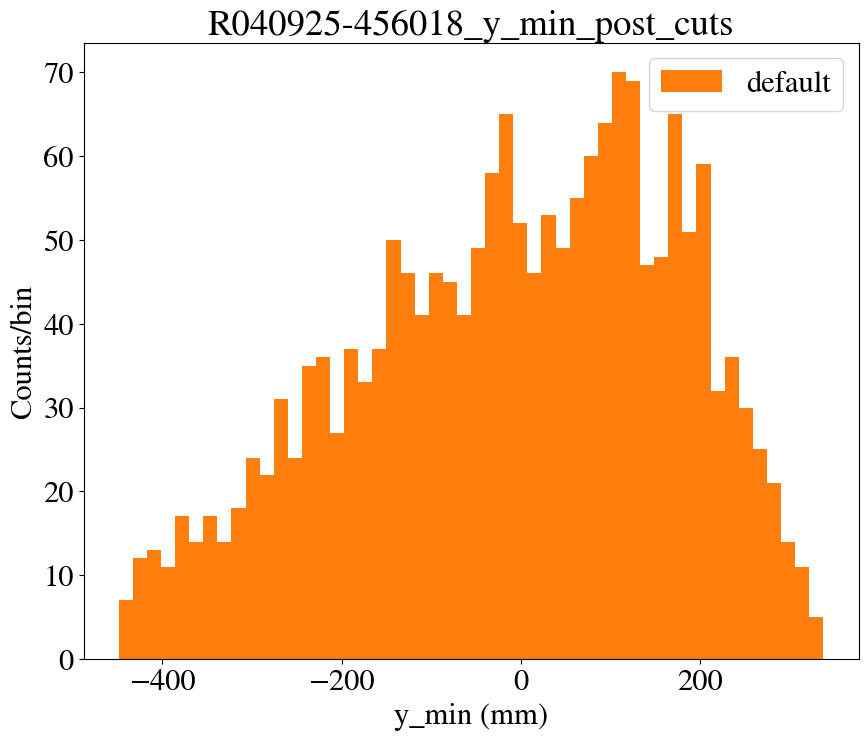

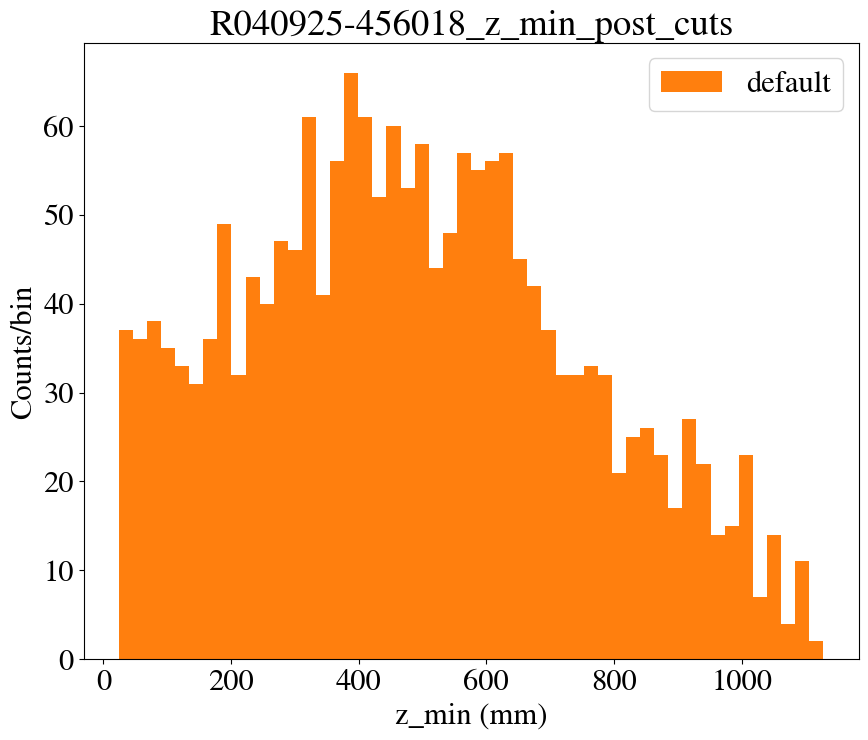

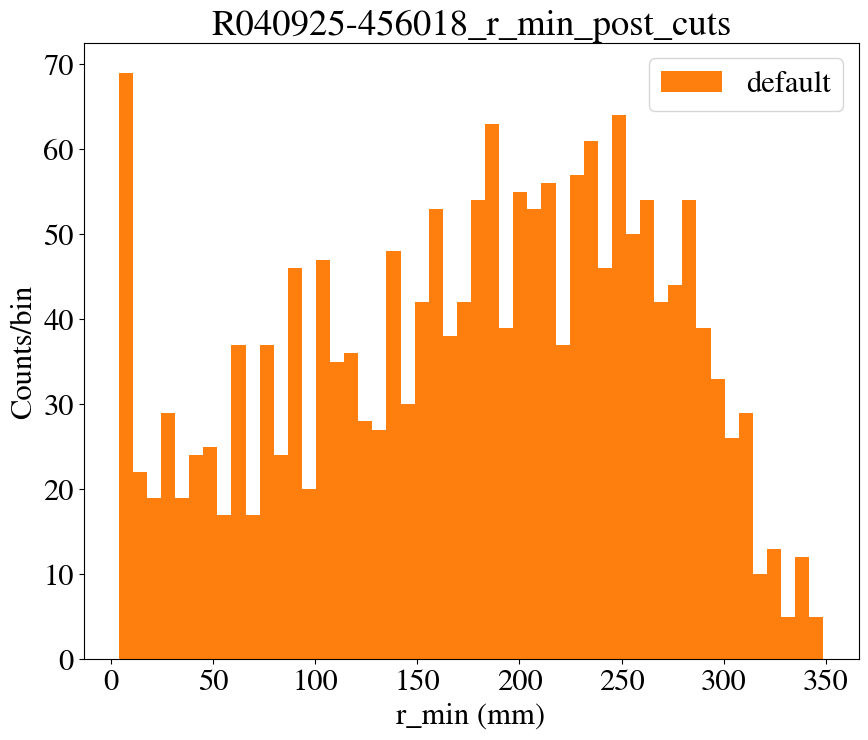

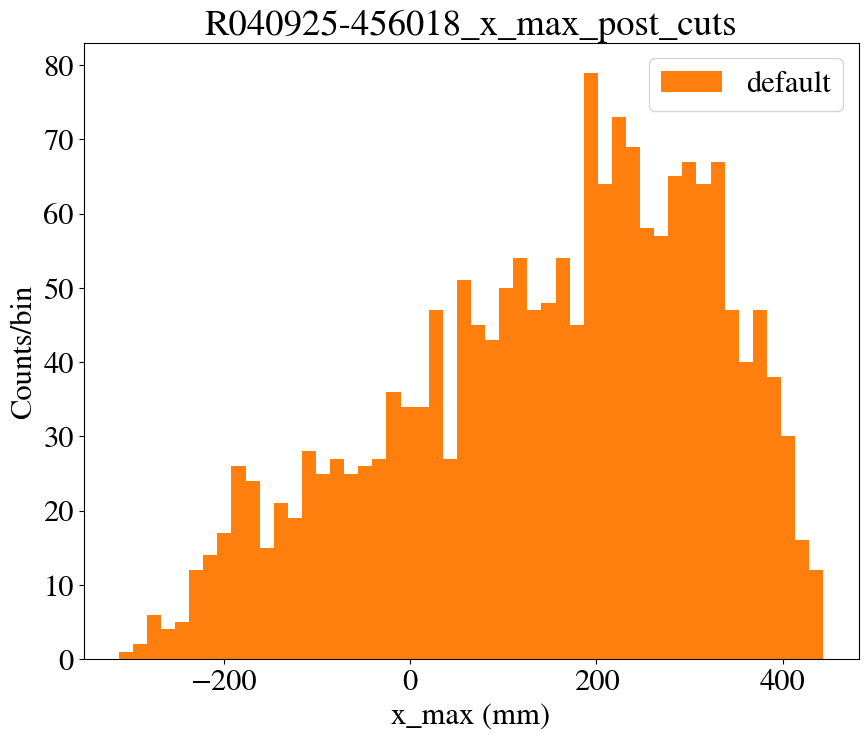

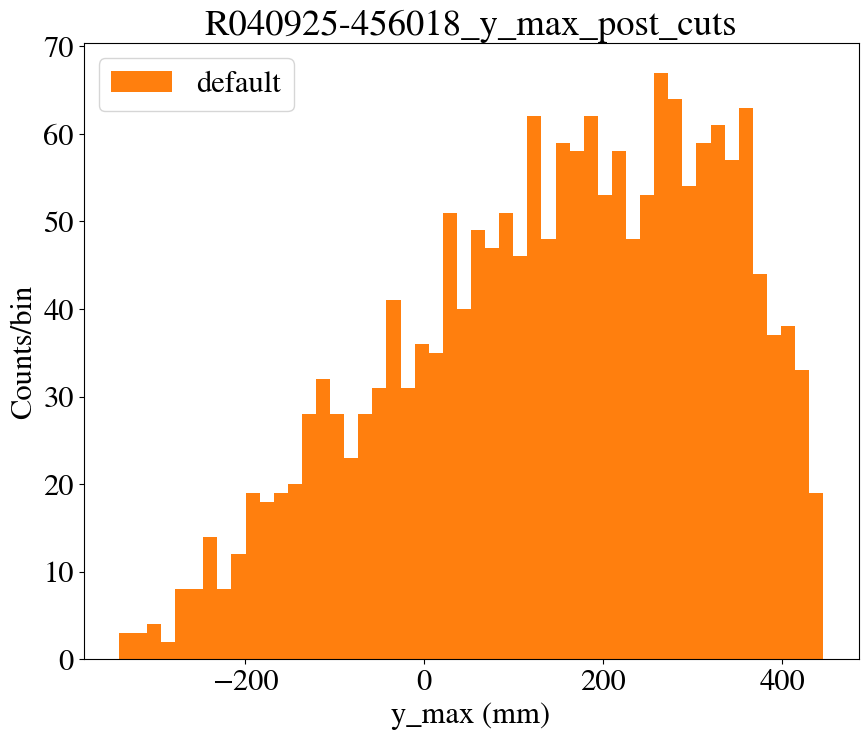

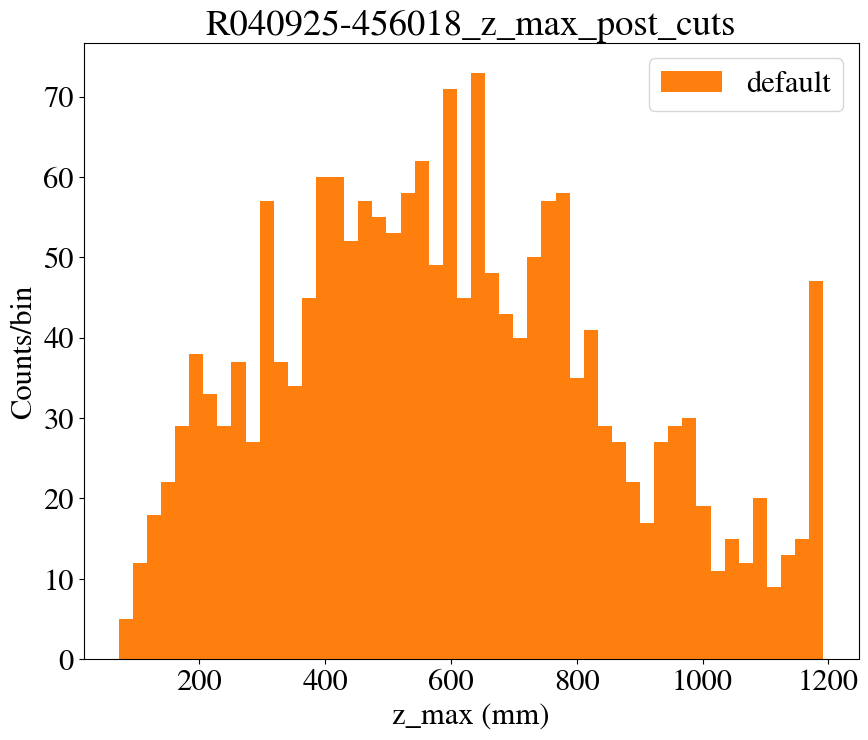

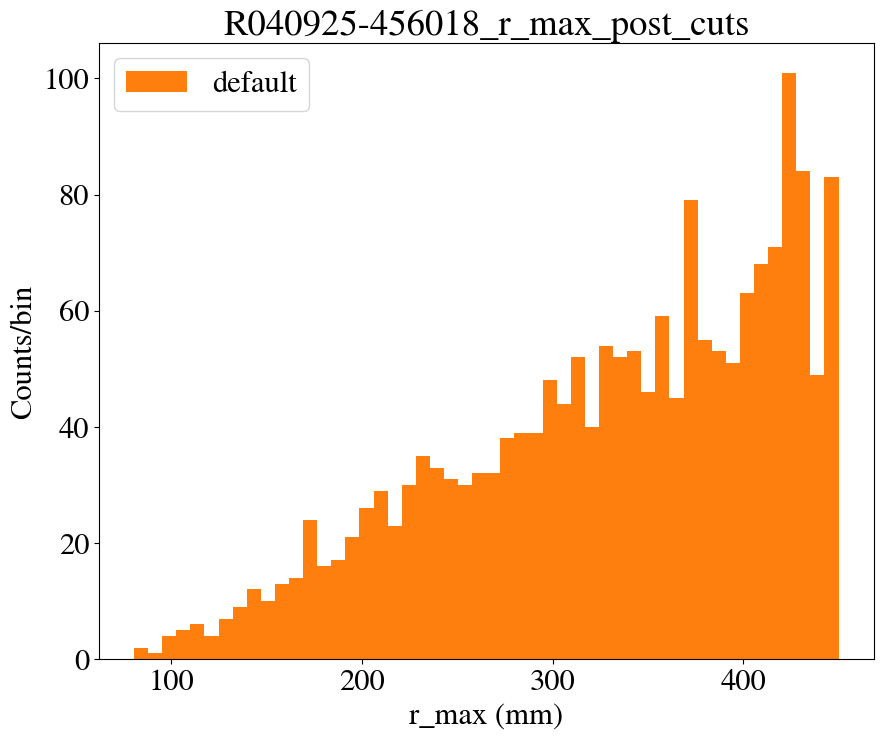

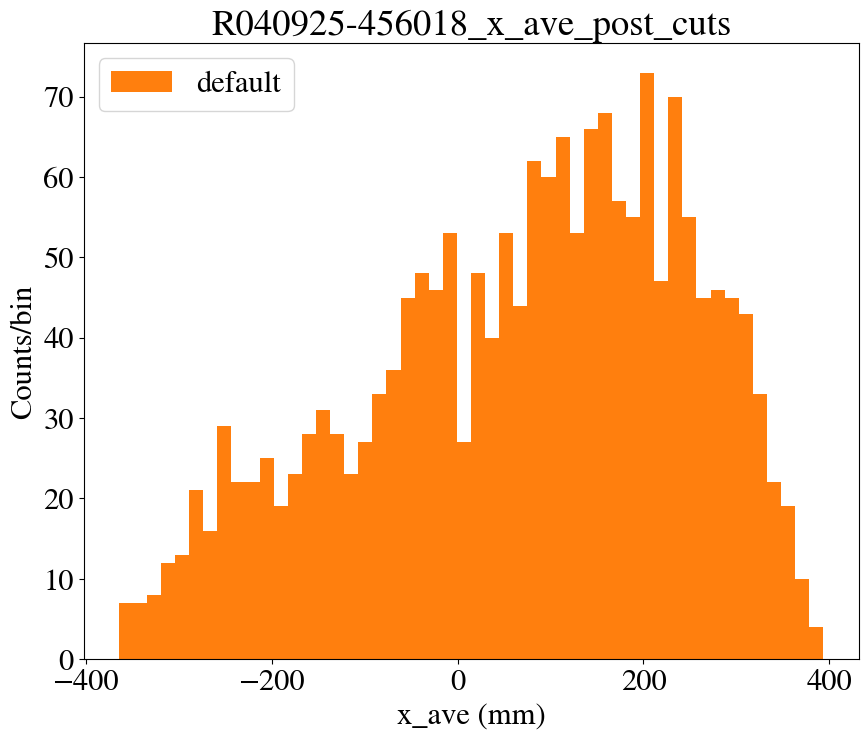

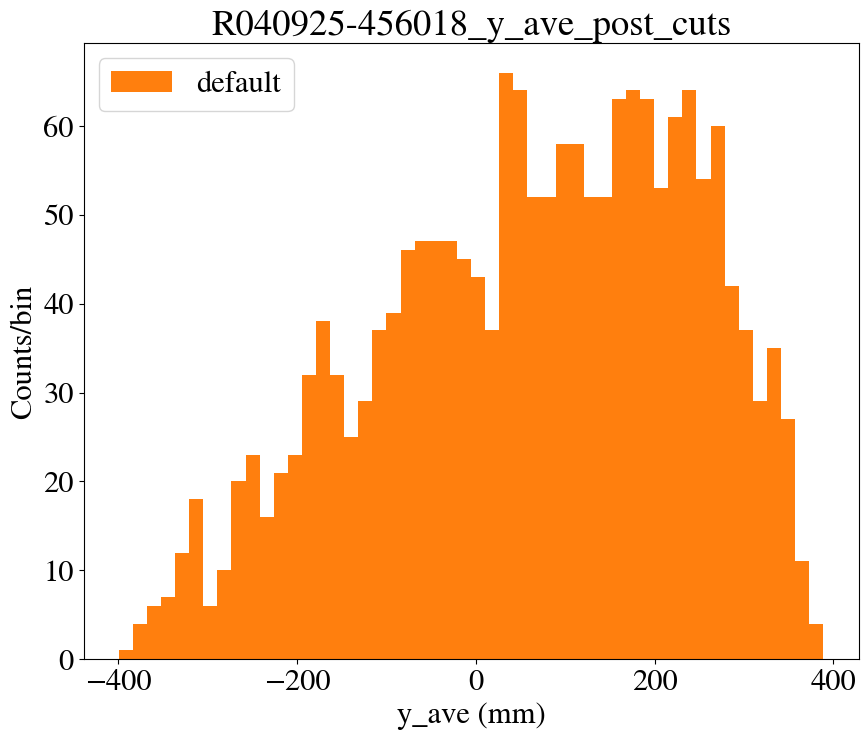

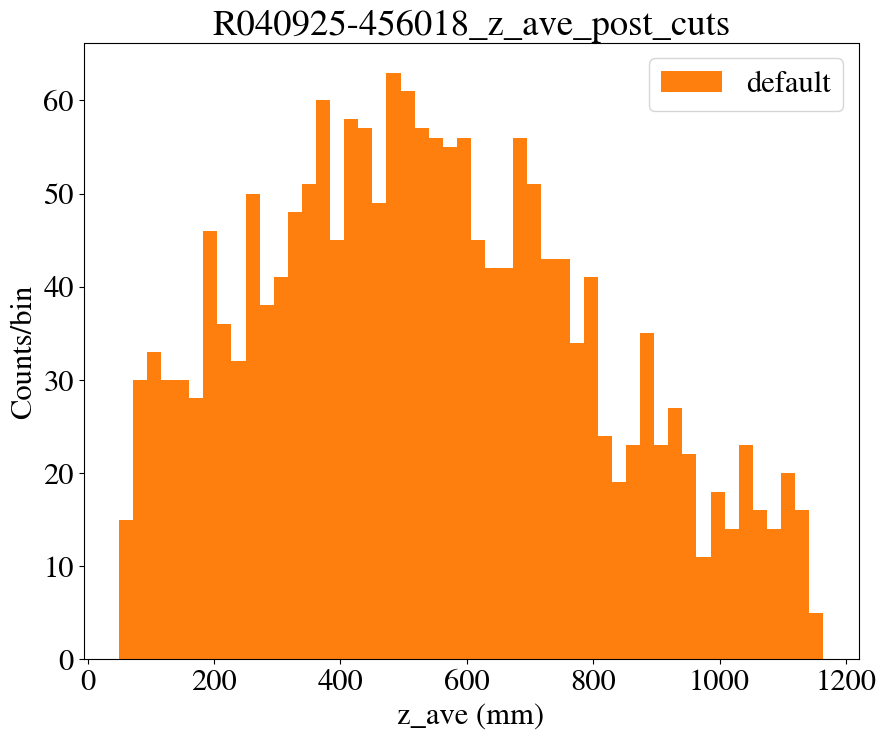

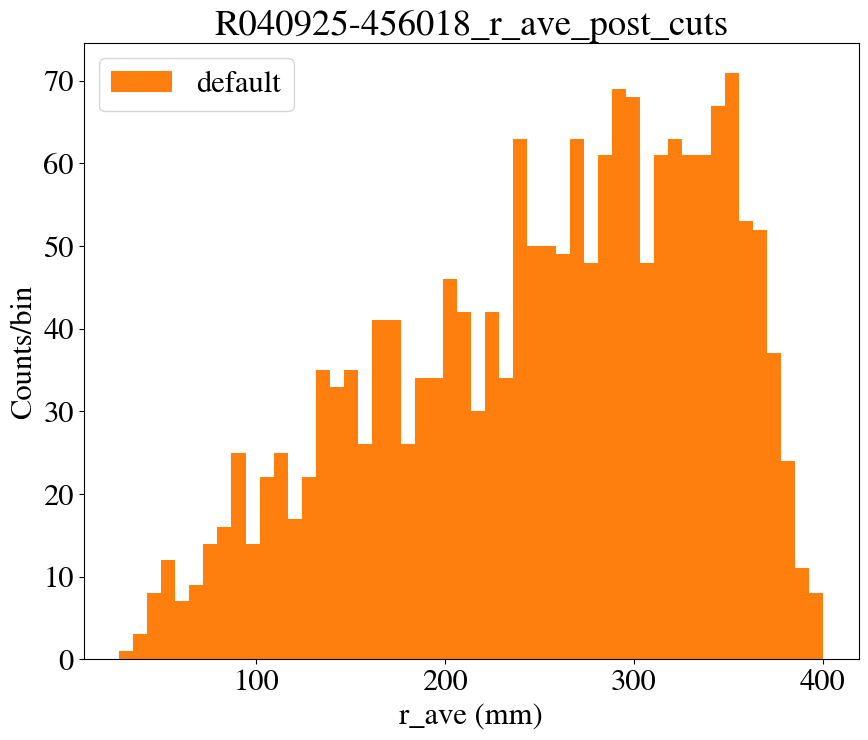

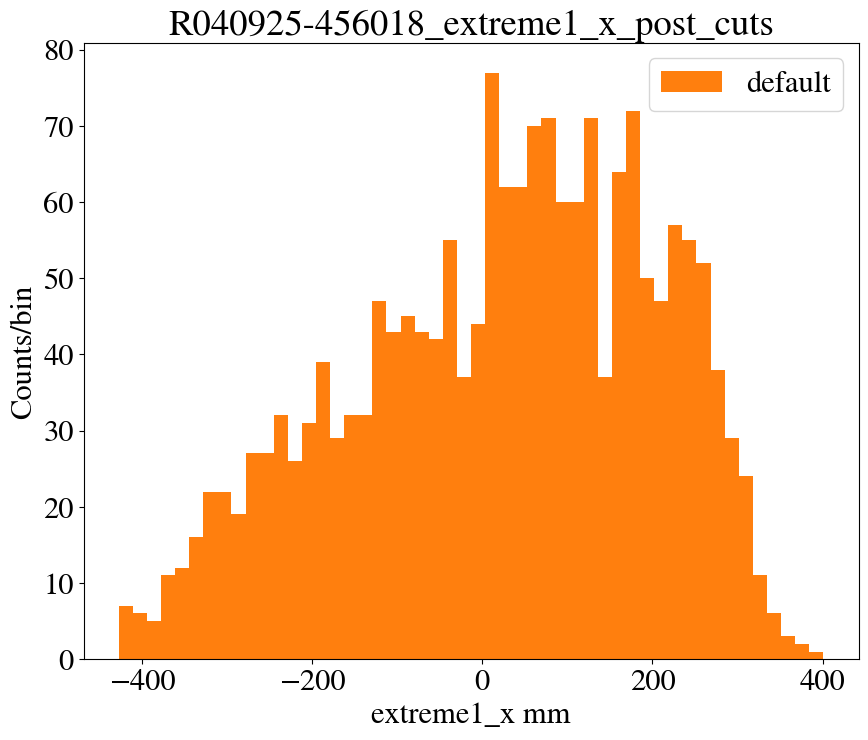

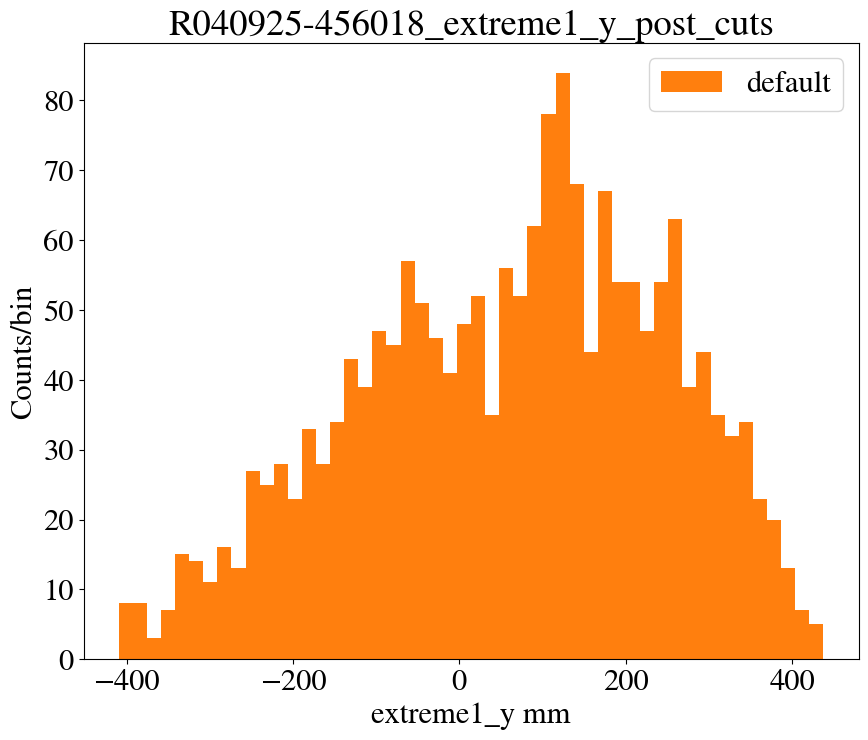

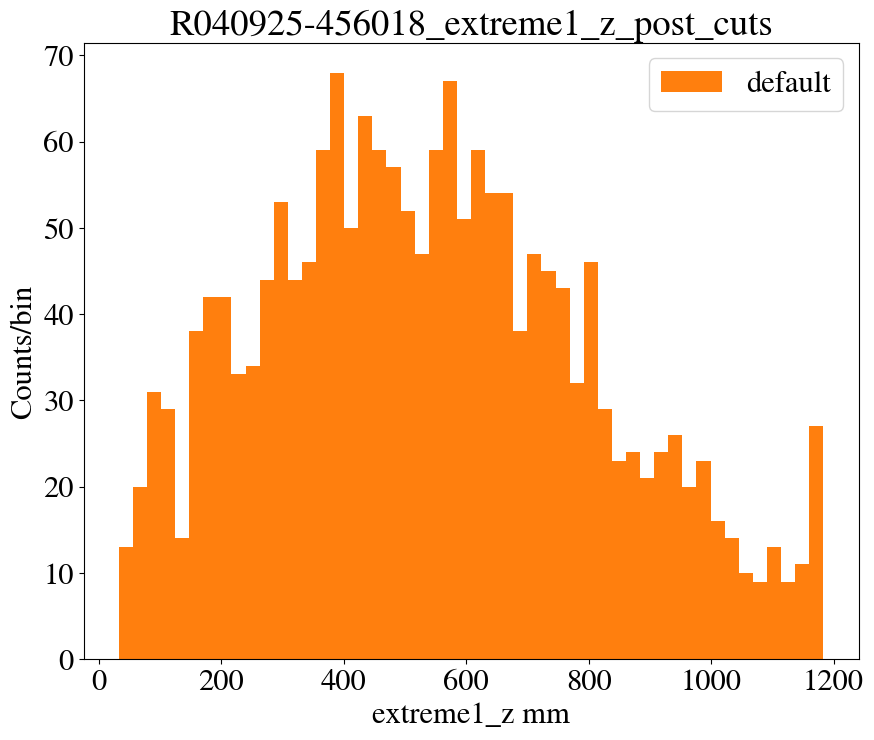

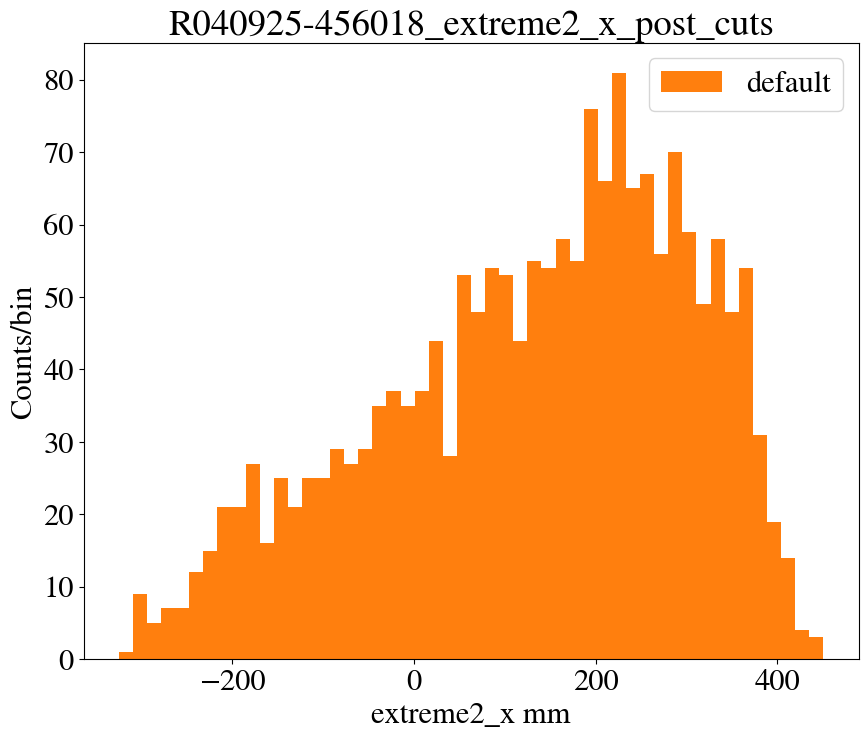

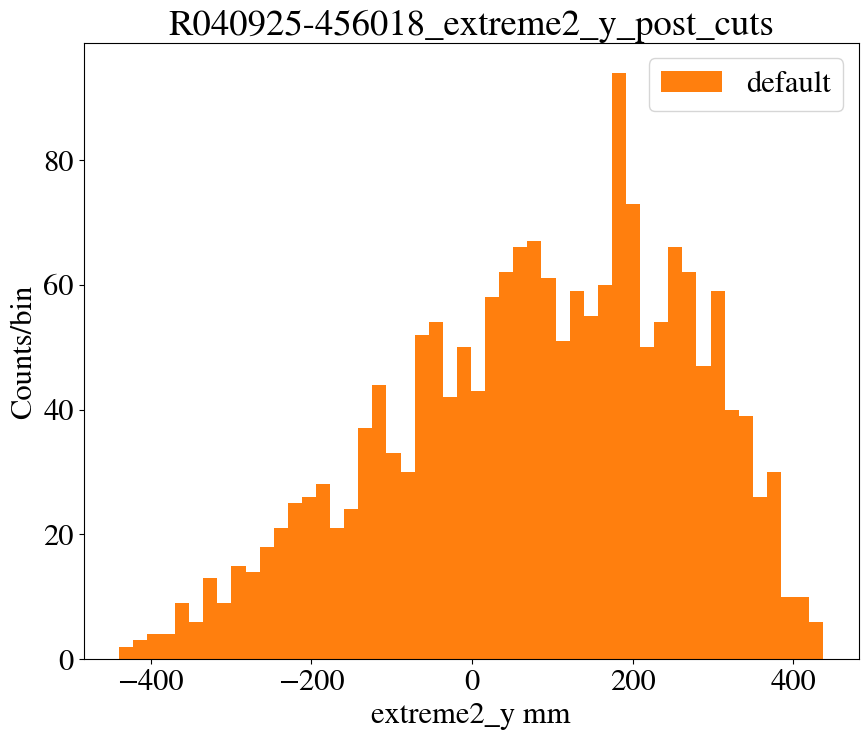

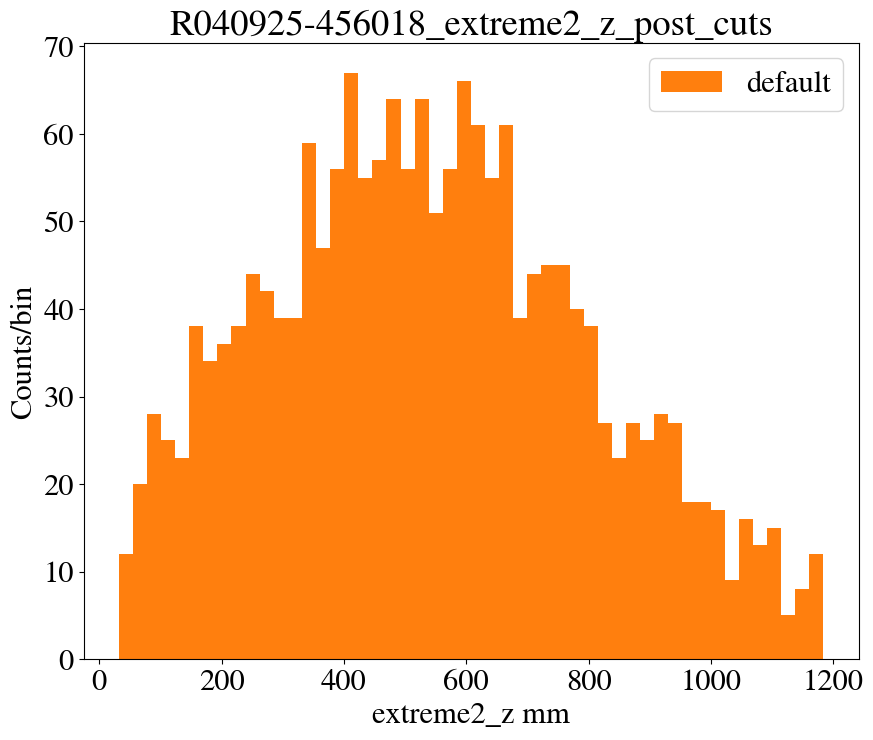

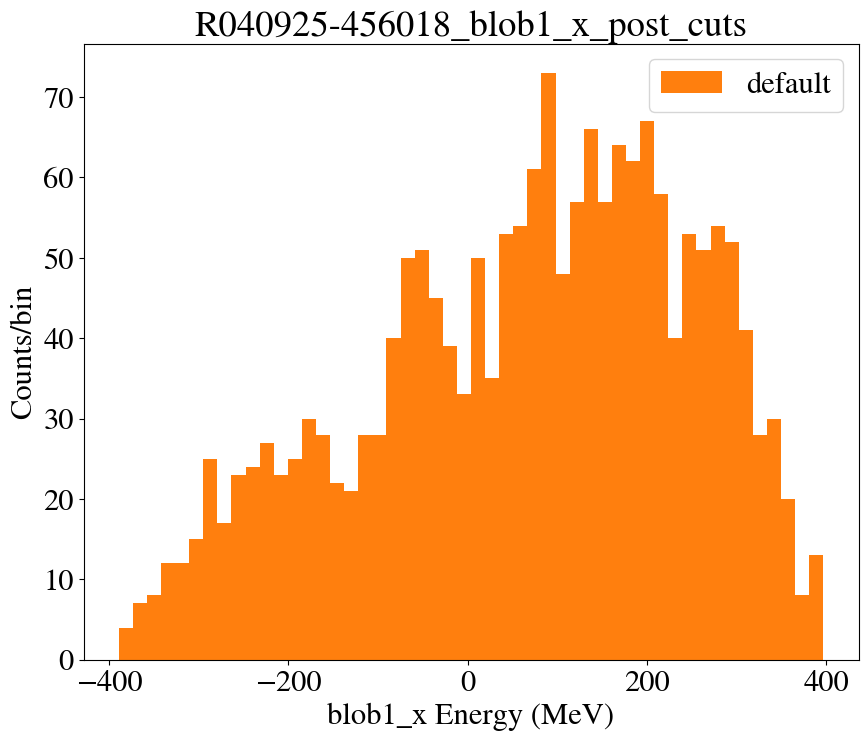

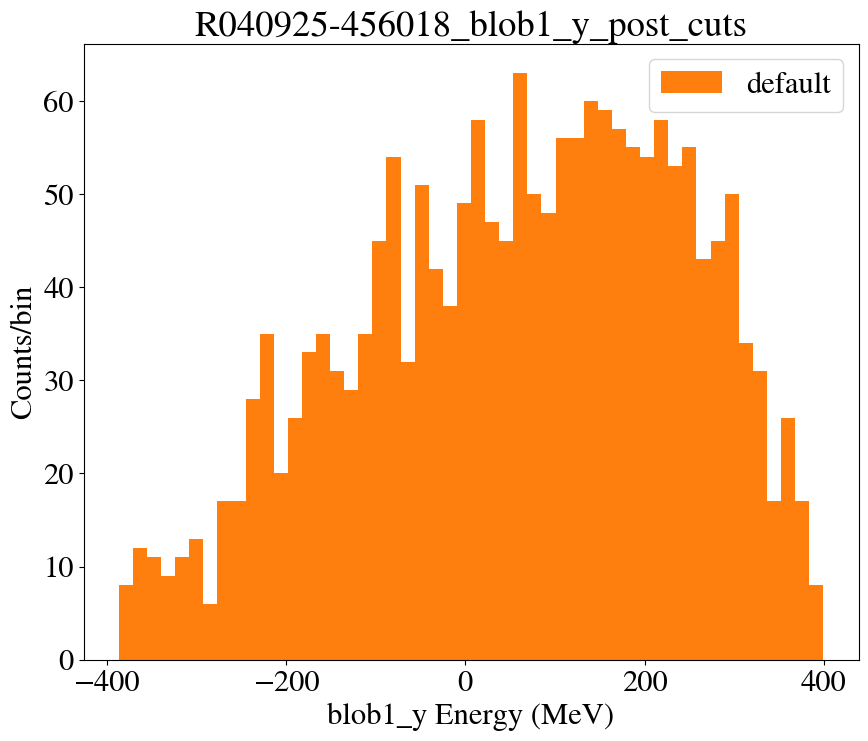

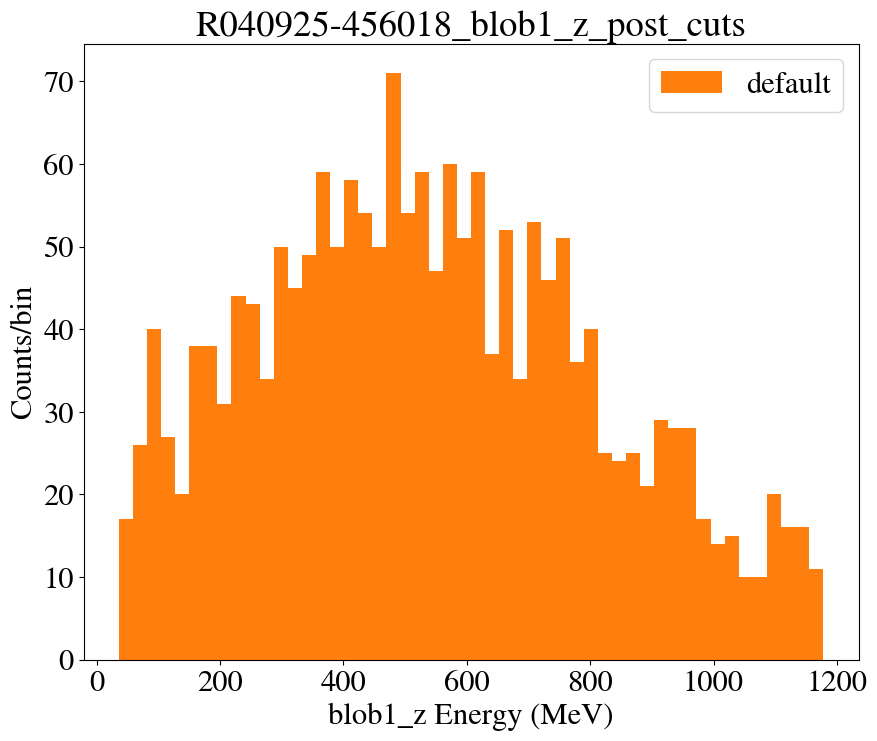

In [28]:
log_flag = False
#############################################################
##################### TOPOLOGICAL ###########################
#############################################################

for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')
    

#############################################################
###################### GEOMETRIC ############################
#############################################################

for vars, labels in zip(geo_vars, geo_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}geometry/')
    
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( cut_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_cuts'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

# look at satellites here

Maximal number of tracks: 0        2
1        2
2        2
3        2
4        4
        ..
33570    2
33571    2
33572    2
33573    2
33574    1
Name: numb_of_tracks, Length: 250051, dtype: int64


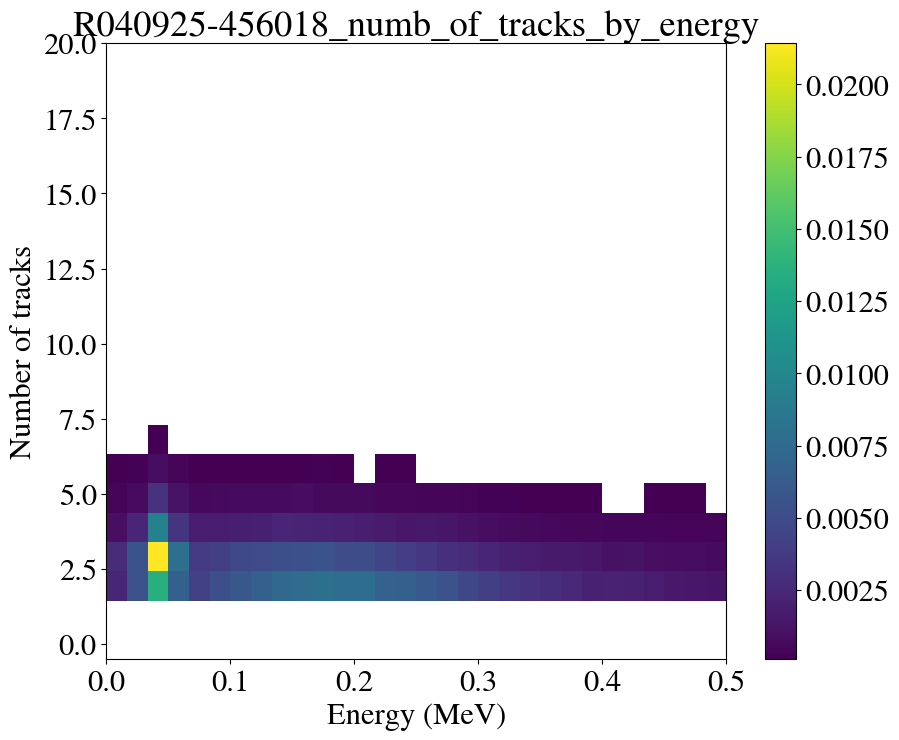

In [29]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = hdst.energy
track_no = hdst.numb_of_tracks
# normalise
print(f'Maximal number of tracks: {track_no}')
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
#plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,0.5),(-0.5,20)))
title_trck_num = f'R{RUN_NUMBER}-{TIMESTAMP}_numb_of_tracks_by_energy'
plt.title(f'{title_trck_num}')
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.savefig(f'{folder_name}energy/{title_trck_num}.png')
plt.show()

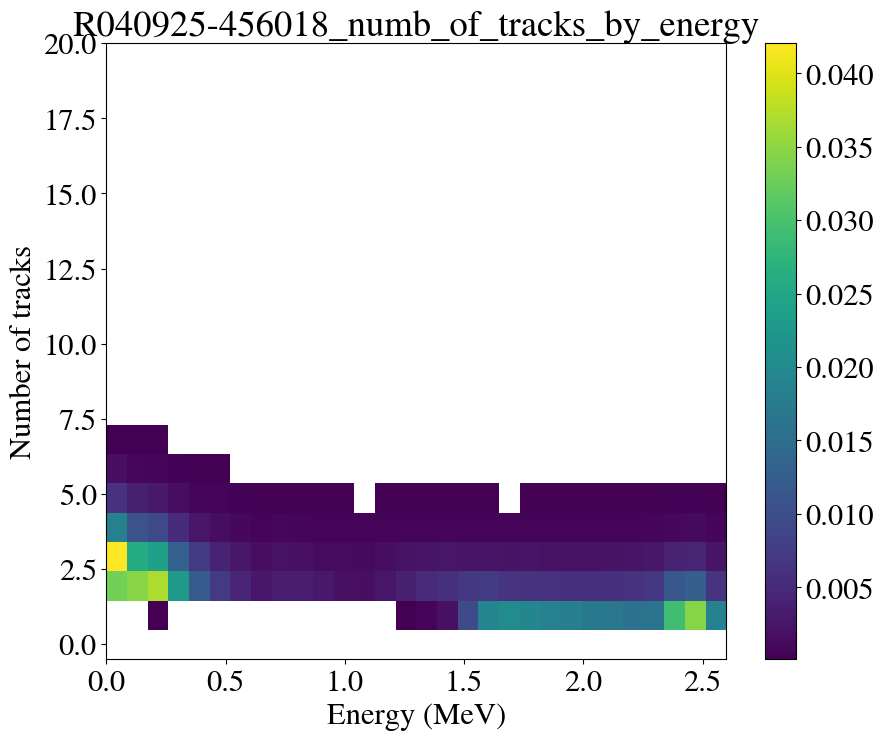

In [30]:
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,2.6),(-0.5,20)))
title_trck_num = f'R{RUN_NUMBER}-{TIMESTAMP}_numb_of_tracks_by_energy'
plt.title(f'{title_trck_num}')
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.show()

# And blob 1 blob 2 distributions

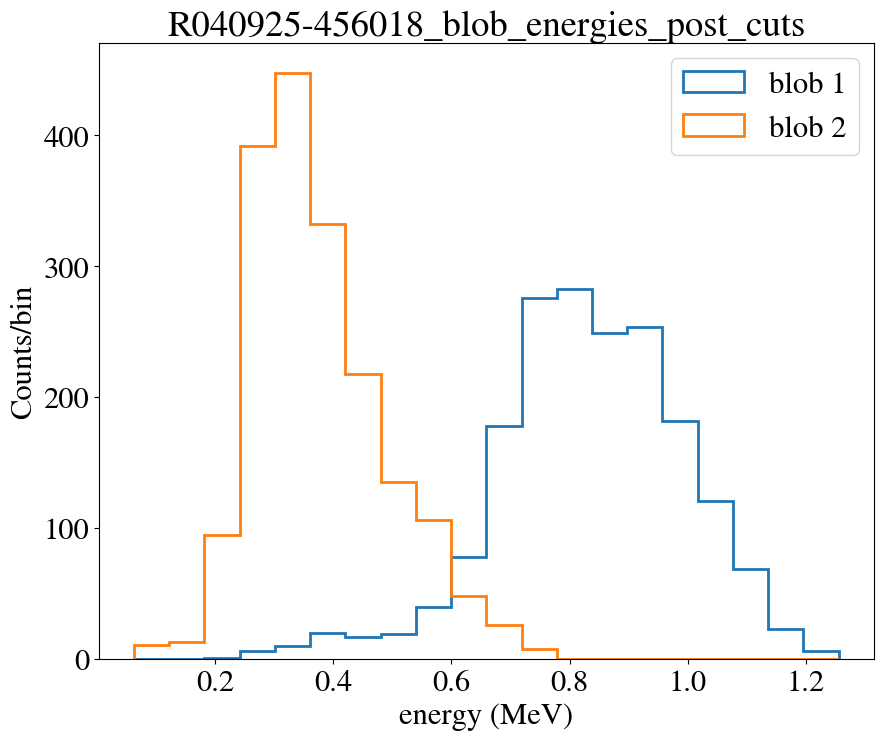

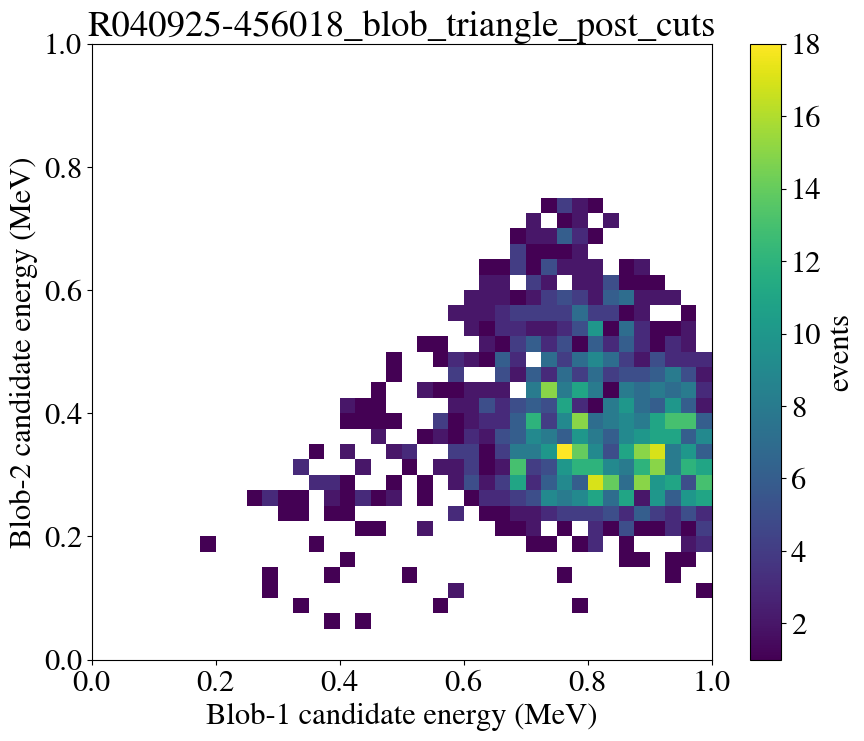

In [31]:
blob_title        = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_energies_post_cuts'
blob_2dhits_title = f'R{RUN_NUMBER}-{TIMESTAMP}_blob_triangle_post_cuts'
# make range full range of blob1 and blob2
eblob_full = []
eblob_full.append(cut_hdst['eblob1'].to_numpy())
eblob_full.append(cut_hdst['eblob2'].to_numpy())

minimum_e = np.min(eblob_full)
maximum_e = np.max(eblob_full)

func.plot_hist(cut_hdst, column = 'eblob1', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 1', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
func.plot_hist(cut_hdst, column = 'eblob2', binning = 20, title = f'{blob_title}', output = False, fill = False, label = 'blob 2', x_label = 'energy (MeV)', range = (minimum_e, maximum_e), log = False)
plt.savefig(f'{folder_name}blob/{blob_title}.png')
plt.legend()
plt.show()

# blob 2dhist
plt.hist2d(cut_hdst['eblob1'], cut_hdst['eblob2'], bins=(40, 40), range=((0, 1), (0, 1)), cmap='viridis', cmin=0.001)
plt.colorbar(label='events')
plt.xlabel("Blob-1 candidate energy (MeV)")
plt.ylabel("Blob-2 candidate energy (MeV)")
plt.title(f'{blob_2dhits_title}')
plt.savefig(f'{folder_name}blob/{blob_2dhits_title}.png')
plt.show()

# cut by cut plots

### fiducial track cut

In [32]:
fid_hdst = func.fiducial_track_cut_2( hdst
                                    , lower_z = low_z
                                    , upper_z = upp_z
                                    , r_lim   = r_lim)

_ = func.cut_effic(fid_hdst, hdst, verbose = True)

Efficiency: 42.00 %
Events in reduced dataframe: 95005
Events in initial dataframe: 250051


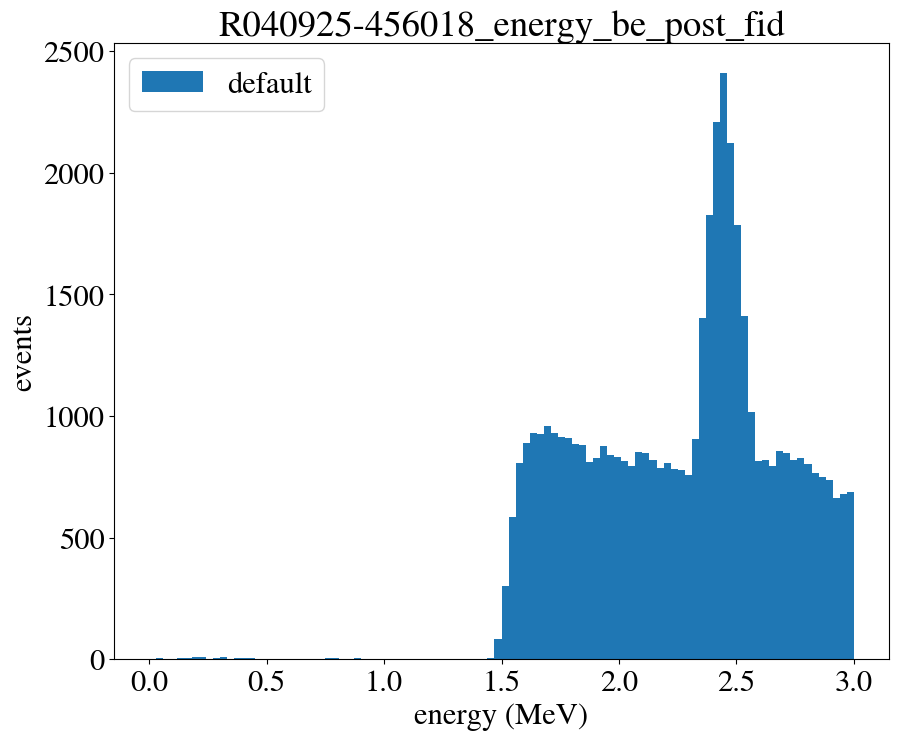

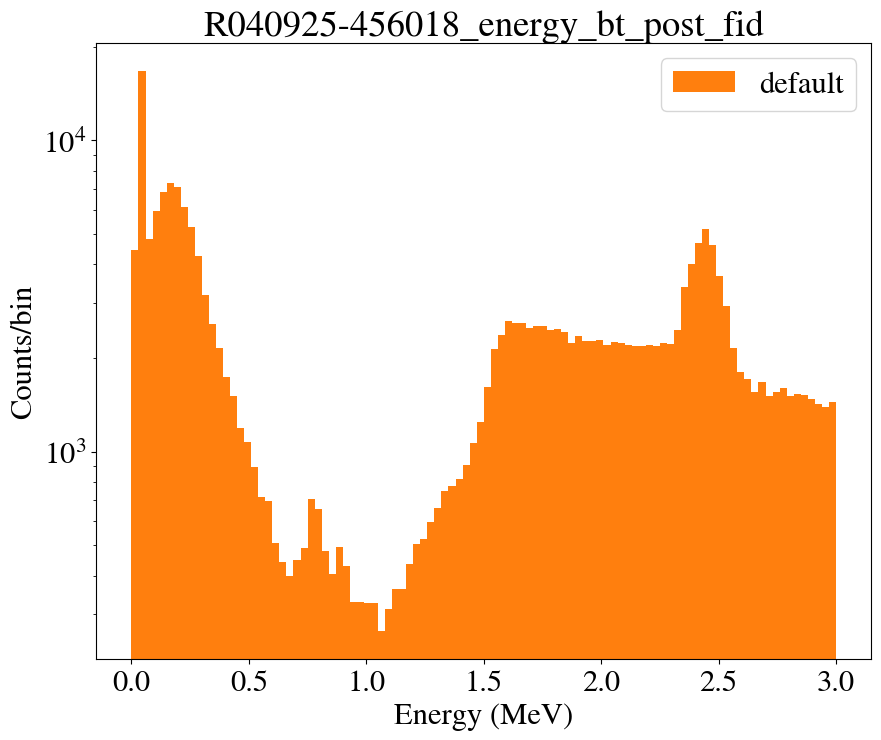

In [33]:
func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_fid'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_fid'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# One track cut

In [34]:
ot_hdst = func.one_track_cuts(fid_hdst)

_ = func.cut_effic(ot_hdst, fid_hdst, verbose = True)

Efficiency: 69.45 %
Events in reduced dataframe: 46566
Events in initial dataframe: 95005


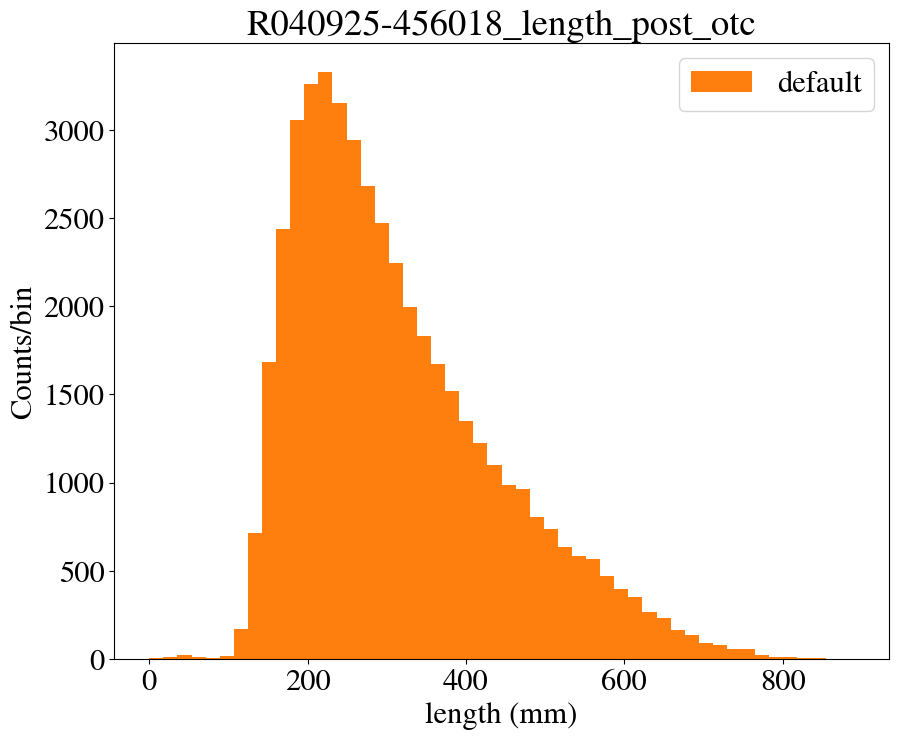

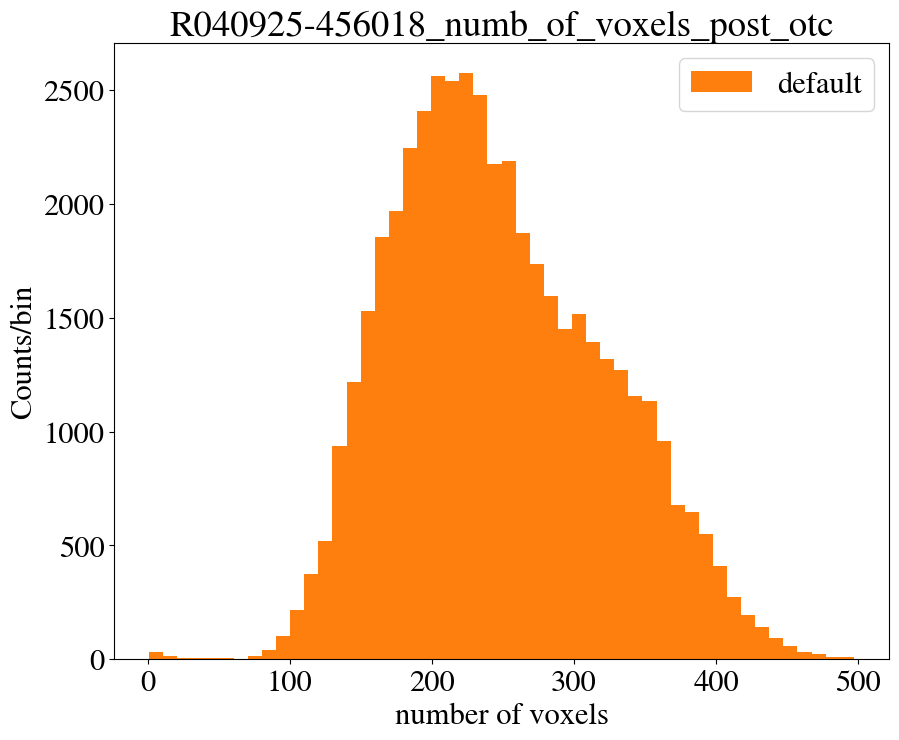

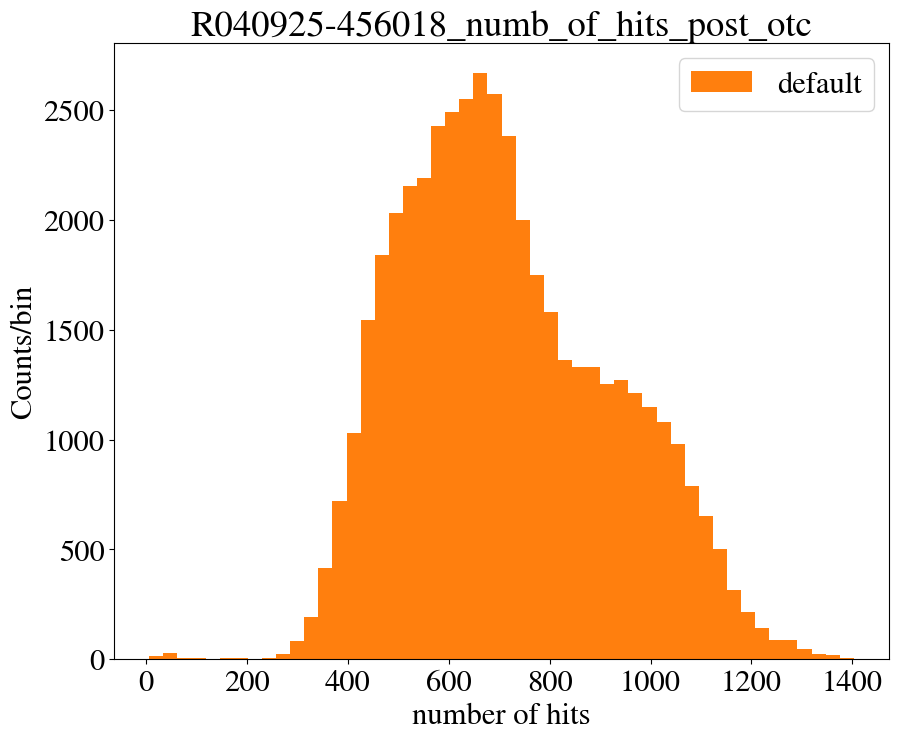

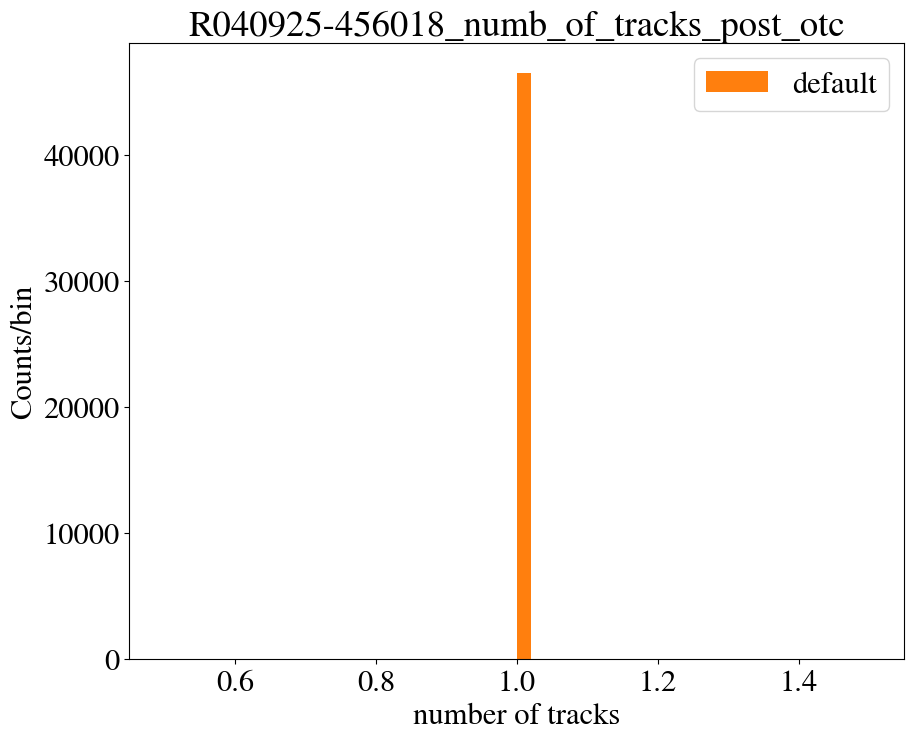

In [35]:
# plot track related shenanigans
for vars, labels in zip(top_vars, top_labels):
    func.plot_hist( ot_hdst
                  , vars
                  , binning  = 50
                  , title    = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_otc'
                  , x_label  = f'{labels}'
                  , outliers = (0, 99.99999)
                  , log      = log_flag
                  , output   = True
                  , save     = True
                  , save_dir = f'{folder_name}topology/')

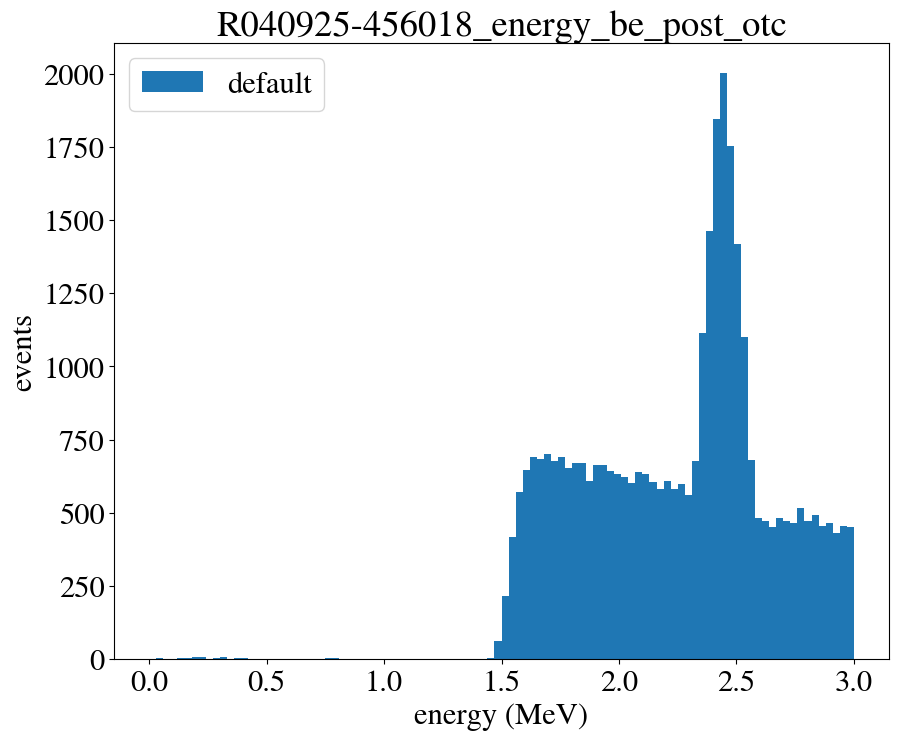

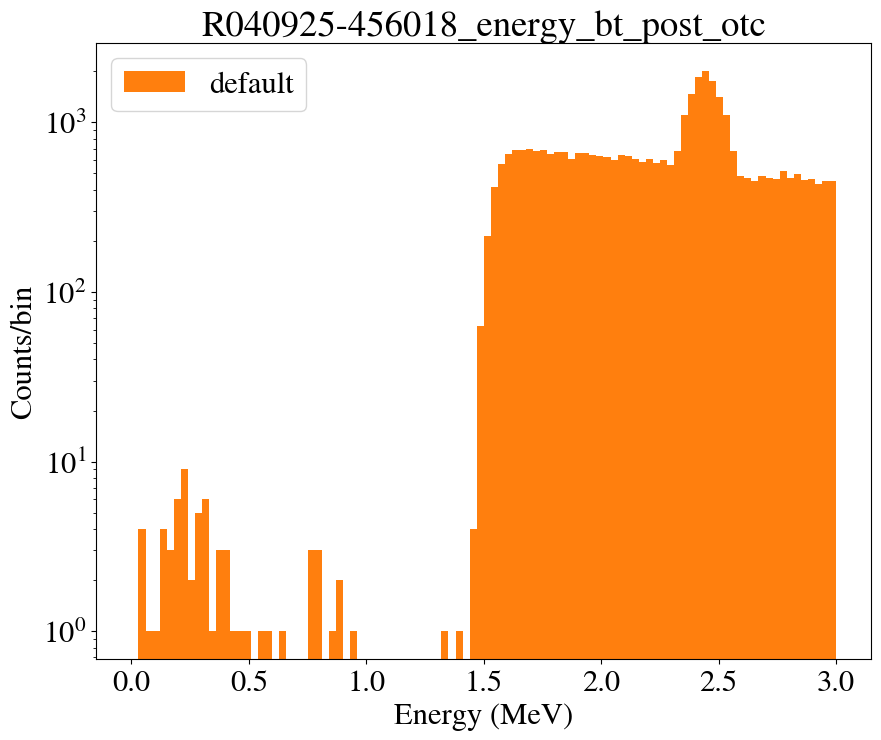

In [36]:
func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_otc'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( ot_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_otc'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# overlap cut

In [37]:
ovlp_hdst = func.overlapping_cuts(ot_hdst)

_ = func.cut_effic(ovlp_hdst, ot_hdst, verbose = True)

Efficiency: 84.90 %
Events in reduced dataframe: 39535
Events in initial dataframe: 46566


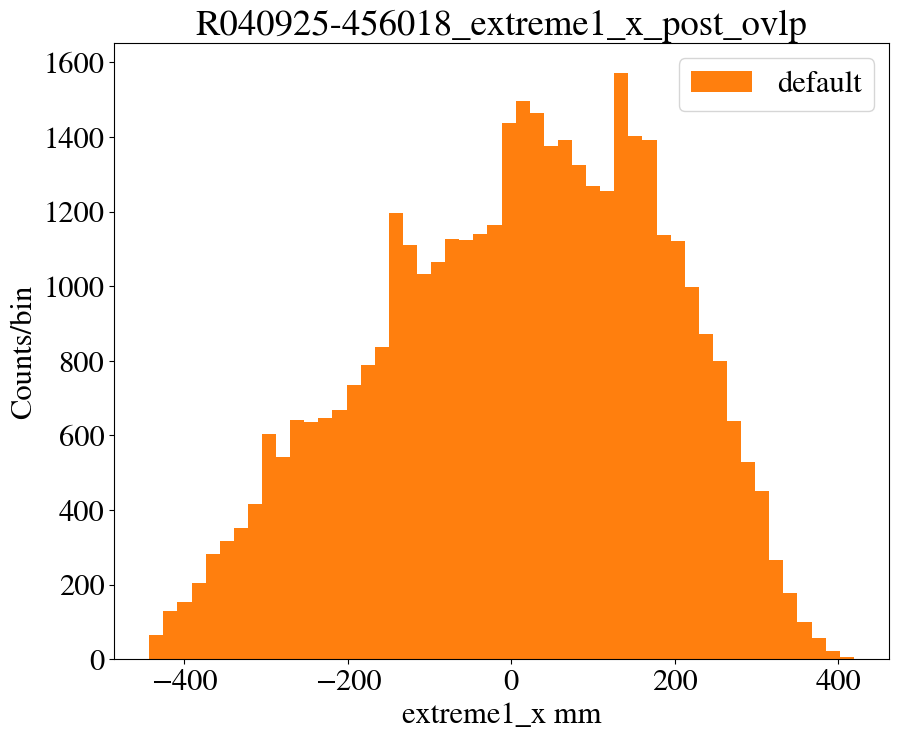

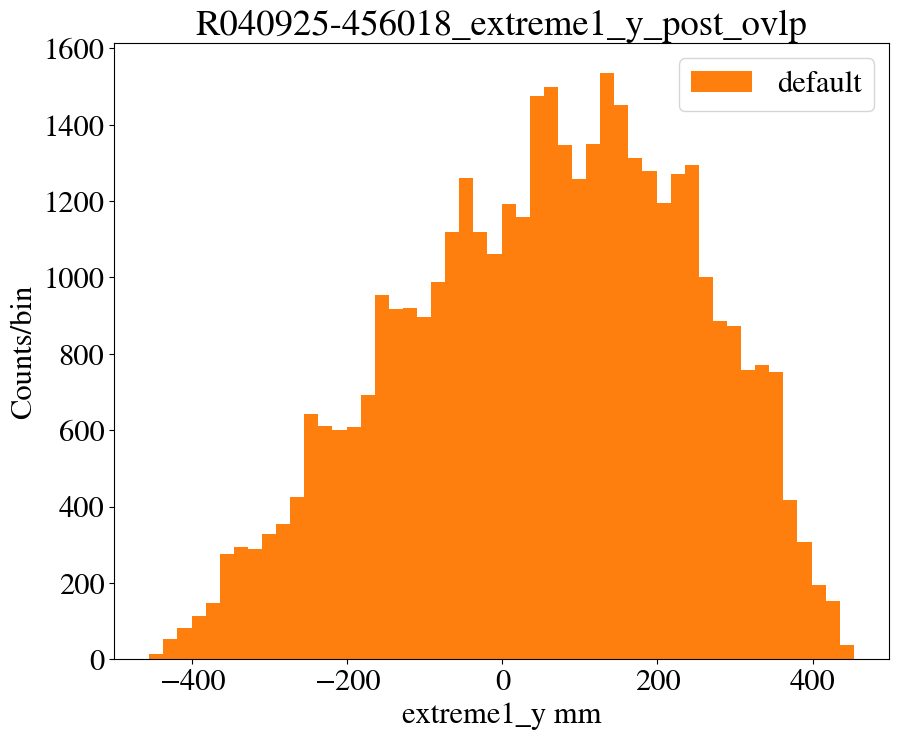

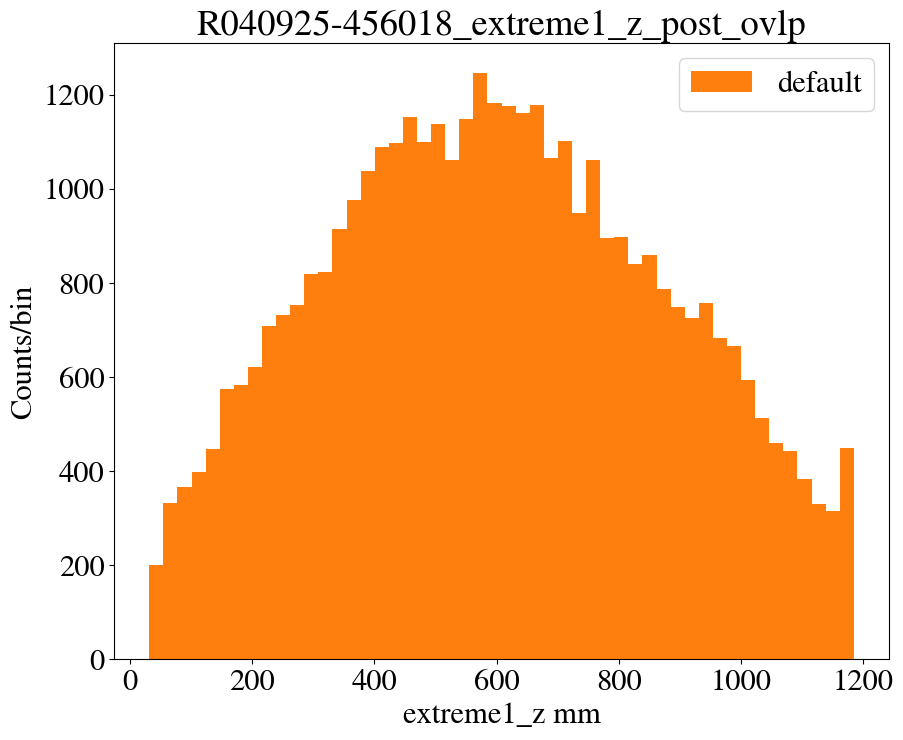

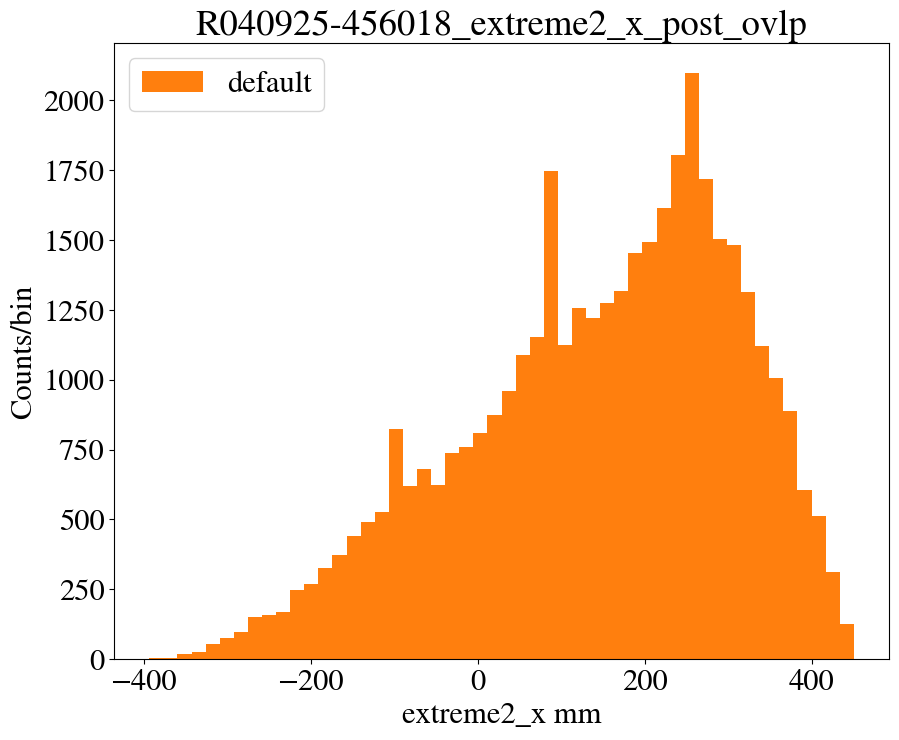

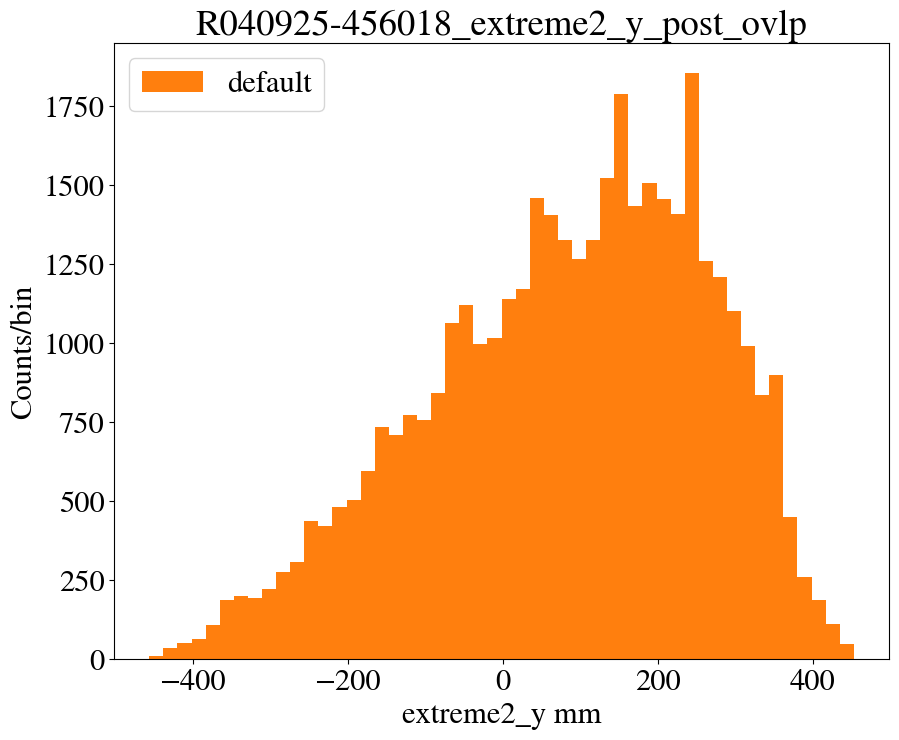

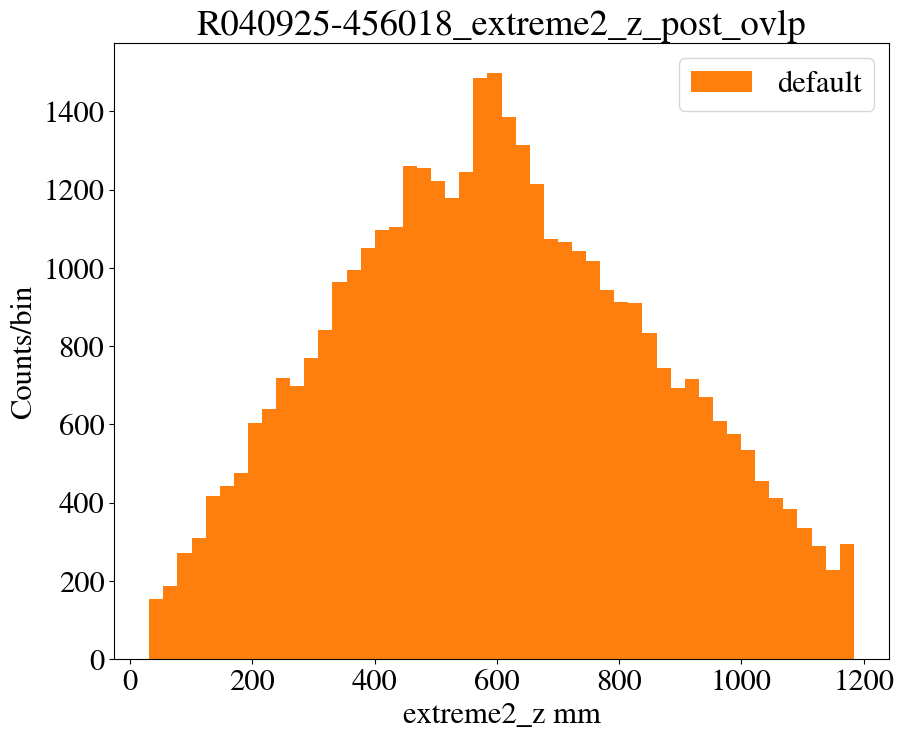

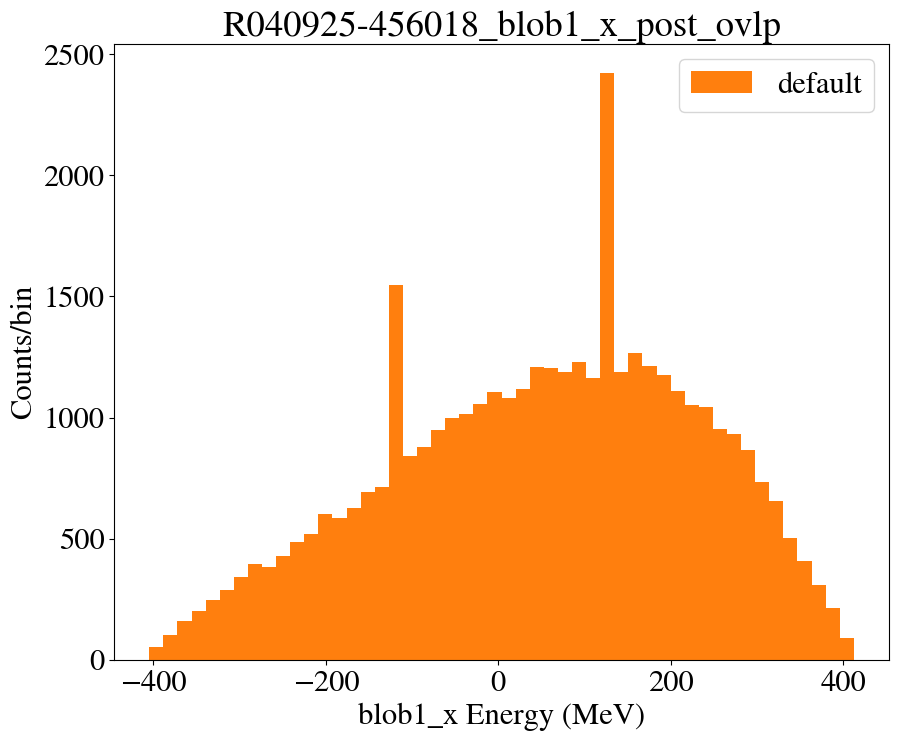

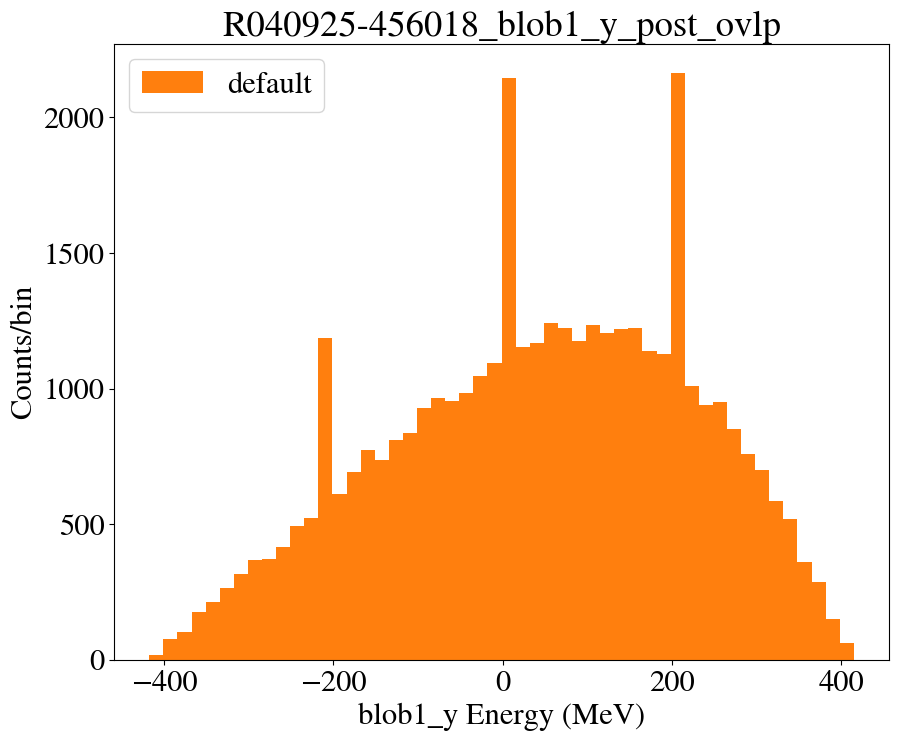

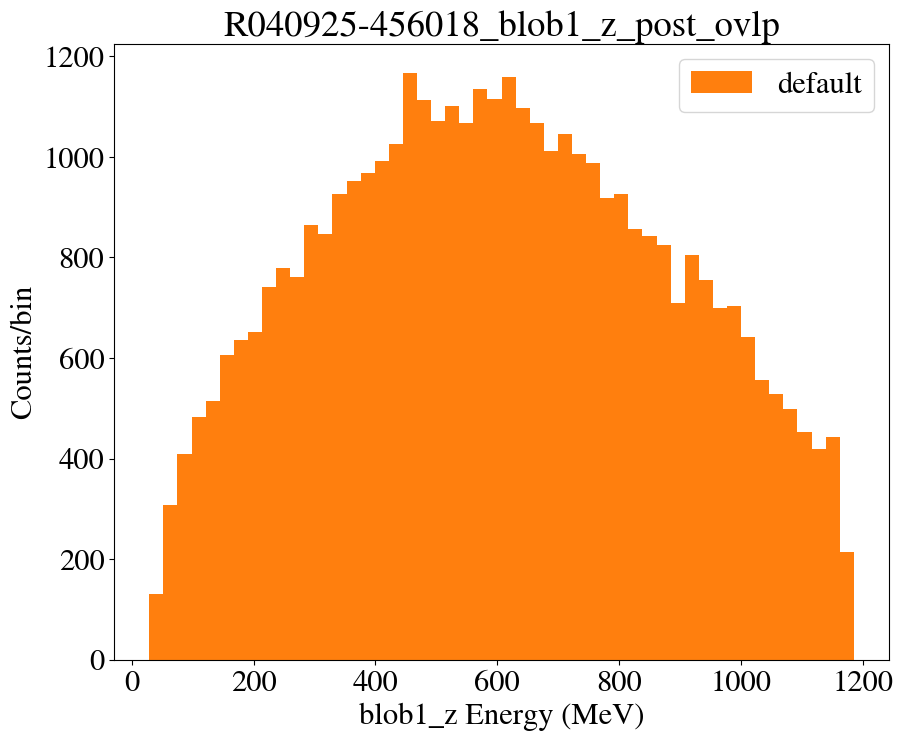

In [38]:
for vars, labels in zip(blob_vars, blob_labels):
    func.plot_hist( ovlp_hdst
                  , vars
                  , binning = 50
                  , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_{vars}_post_ovlp'
                  , x_label = f'{vars} {labels}'
                  #, outliers   = (0, 99.99999)
                  , log     = log_flag
                  , output  = True
                  , save = True
                  , save_dir = f'{folder_name}blob/')

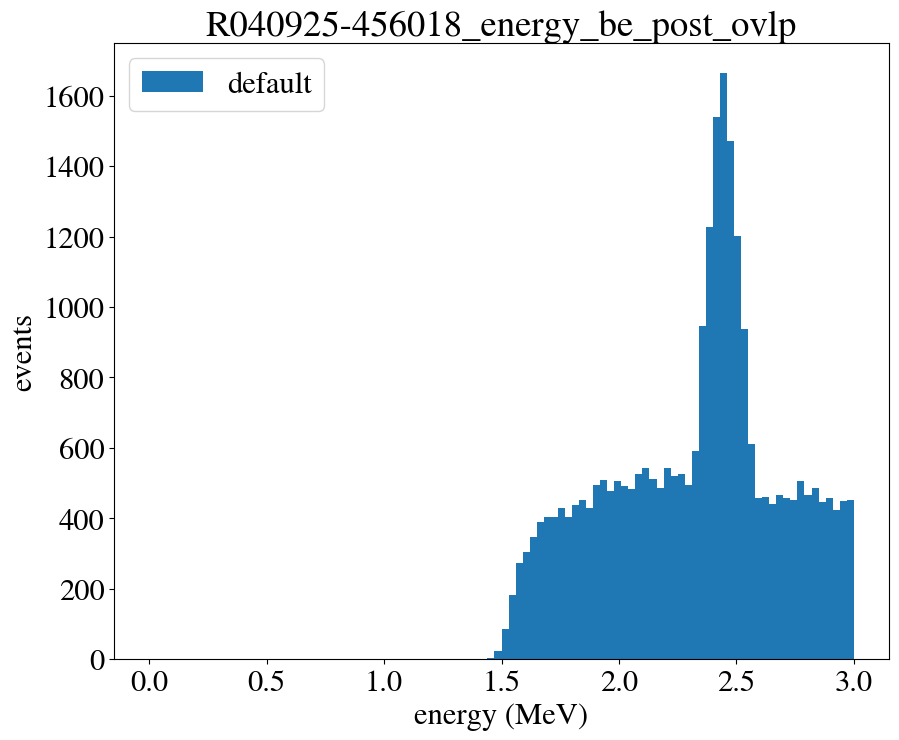

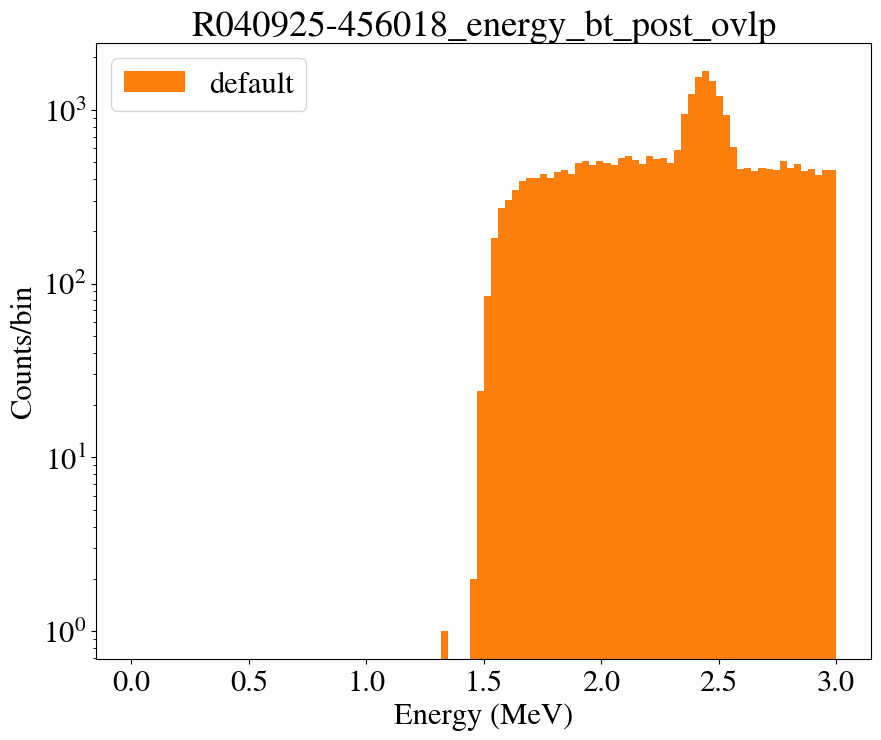

In [39]:
func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_ovlp'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( ovlp_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_ovlp'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# energy cut

In [40]:
e_hdst = func.energy_cuts(ovlp_hdst
                         , lower_e = low_e
                         , upper_e = upp_e)

_ = func.cut_effic(e_hdst, ovlp_hdst, verbose = True)

Efficiency: 4.63 %
Events in reduced dataframe: 1832
Events in initial dataframe: 39535


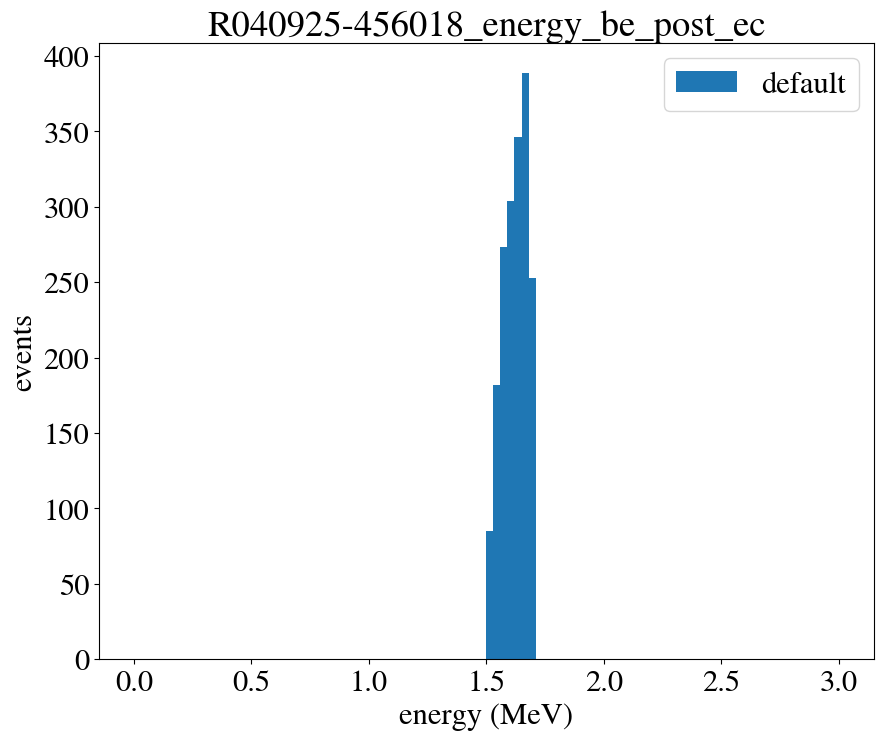

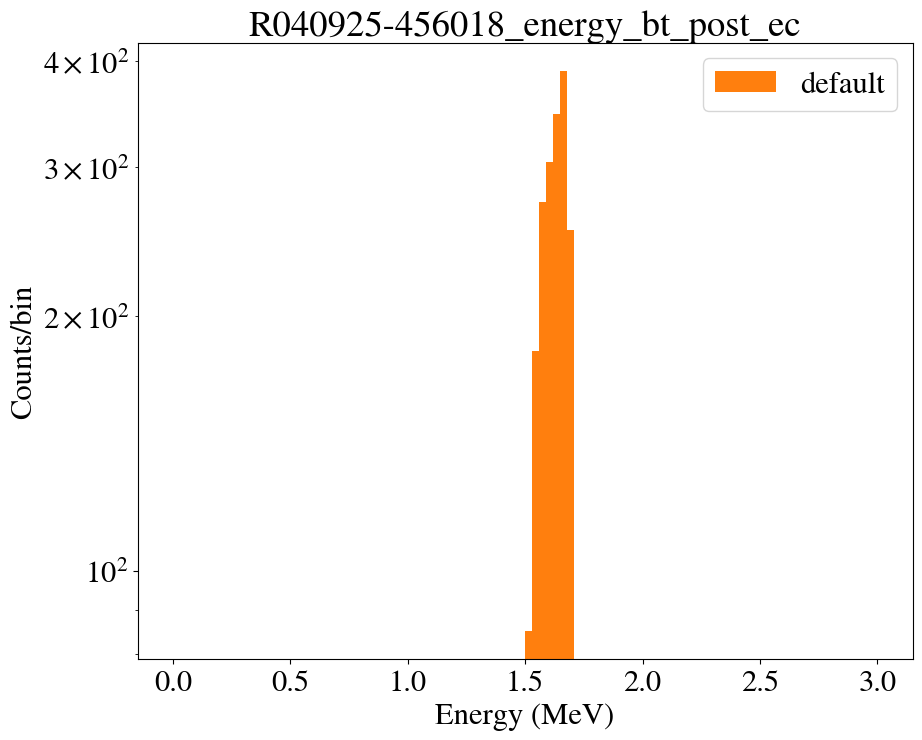

In [41]:
func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_post_ec'
                           , save = True
                           , save_dir = f'{folder_name}energy/')


func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_post_ec'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')


# Now plot the energy histograms atop each other

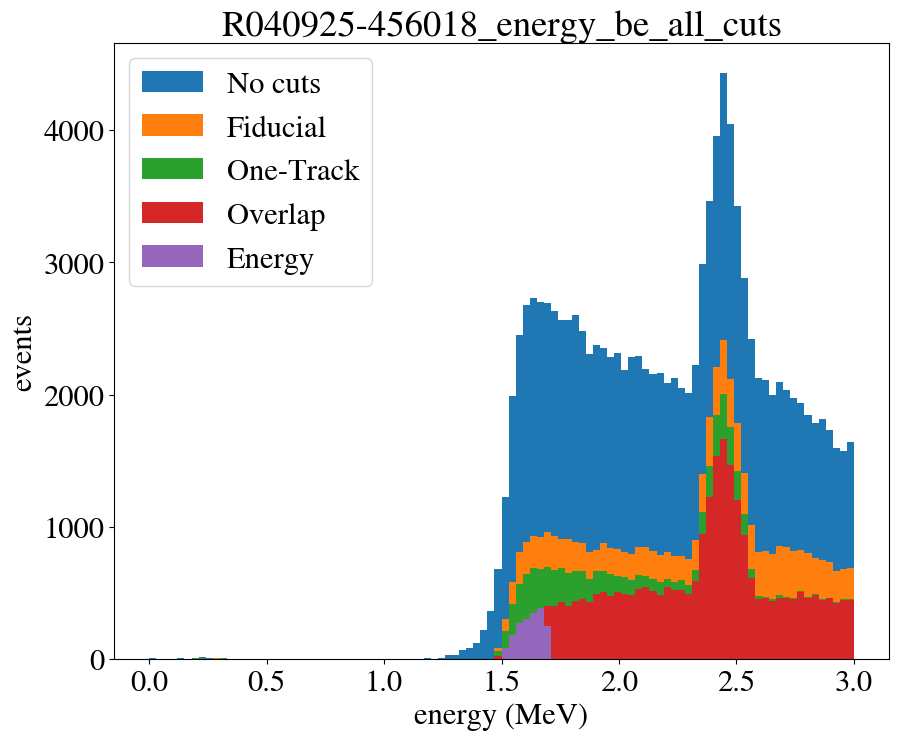

In [42]:
func.plot_hist_over_column(  hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = False
                           , label = f'No cuts'
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Fiducial'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'One-Track'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Overlap'
                           , log = False
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Energy'
                           , log = False
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_all_cuts'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

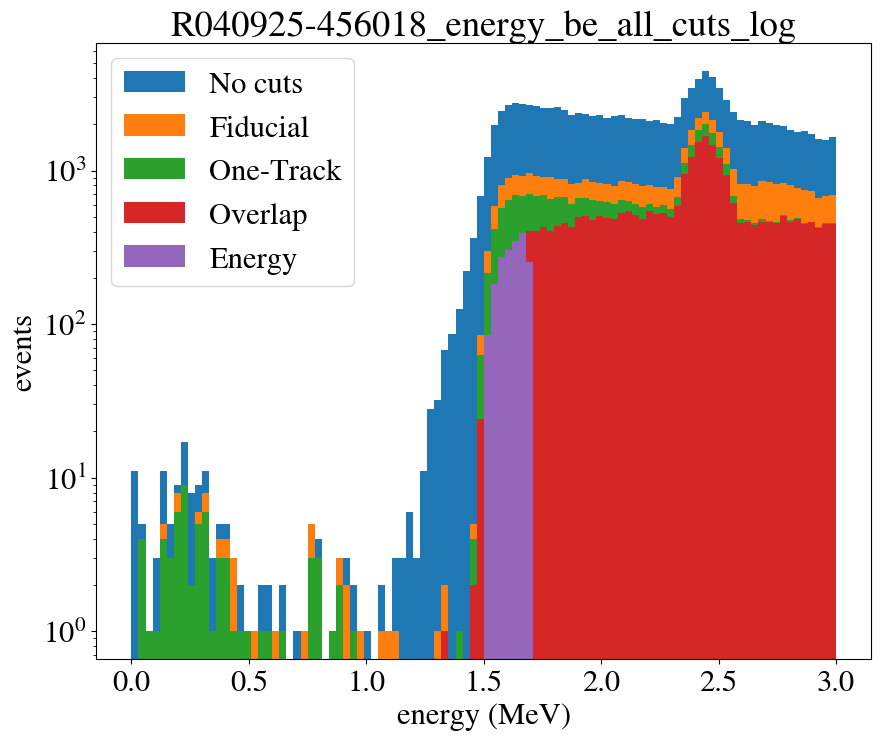

In [43]:
func.plot_hist_over_column(  hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , log = True
                           , label = f'No cuts'
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  fid_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Fiducial'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ot_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'One-Track'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  ovlp_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Overlap'
                           , log = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be')

func.plot_hist_over_column(  e_hdst
                           , 'event'
                           , 'energy'
                           , lambda x: x.sum()
                           , binning = 100
                           , range = (0, 3)
                           , label = f'Energy'
                           , log = True
                           , output = True
                           , title = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_be_all_cuts_log'
                           , save = True
                           , save_dir = f'{folder_name}energy/')

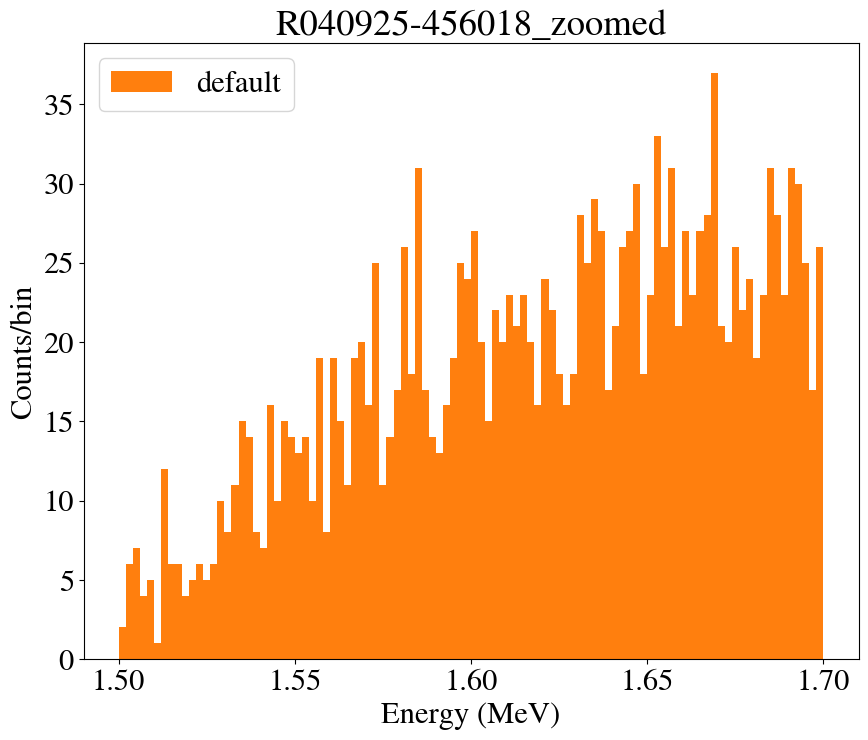

In [44]:
func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_zoomed'
              , x_label = 'Energy (MeV)'
              , range   = (1.5, 1.7)
              , log     = False
              , output  = True
              , save = True
              , save_dir = f'{folder_name}energy/')

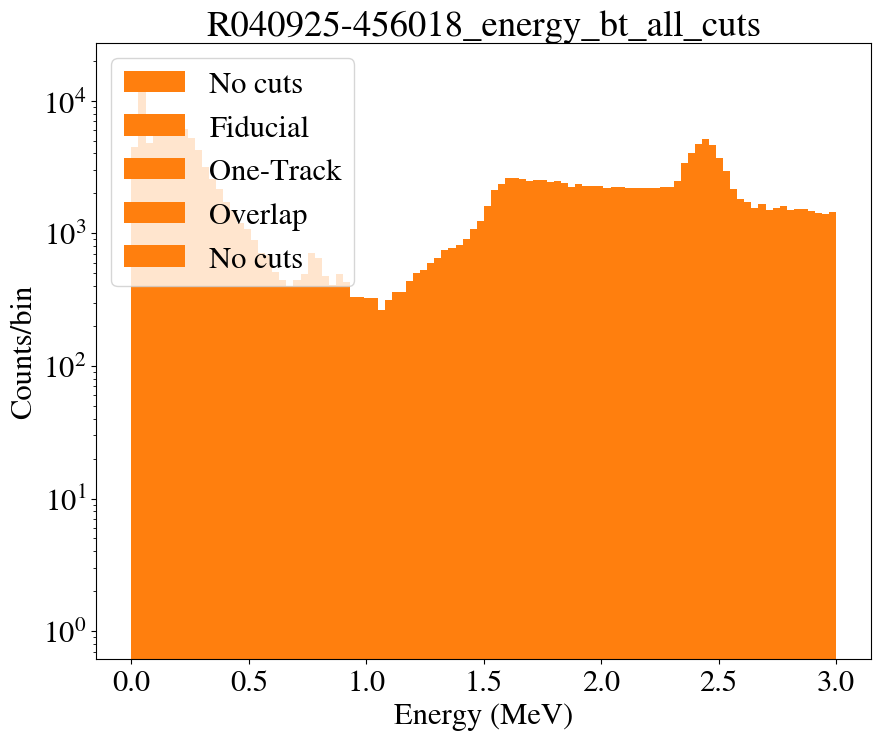

In [45]:
func.plot_hist( hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'No cuts')

func.plot_hist( fid_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'Fiducial')

func.plot_hist( ot_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'One-Track')


func.plot_hist( ovlp_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'Overlap')


func.plot_hist( e_hdst
              , 'energy'
              , binning = 100
              , title   = f'R{RUN_NUMBER}-{TIMESTAMP}_energy_bt_all_cuts'
              , x_label = 'Energy (MeV)'
              , range   = (0, 3)
              , log     = True
              , label   = f'No cuts'
              , output = True
              , save = True
              , save_dir = f'{folder_name}energy/')